# Creación de Archivos SIMLIB para SNANA


Este notebook detalla el procedimiento para analizar una base de datos de [simulación de observaciones (OpSim) del Vera C. Rubin Observatory (LSST)](https://survey-strategy.lsst.io/index.html#), específicamente el baseline v5.0.

El objetivo principal es procesar estos datos y generar los archivos SIMLIB, que son un formato de entrada esencial para las simulaciones utilizando el software SNANA. El código se basa en las herramientas proporcionadas por [OpSimSummaryV2](https://opsimsummaryv2.readthedocs.io/en/latest/basicusage.html) y rubin_sim.

Autores: Valenzuela, M. & Mancilla, I.

### Carga de librerias

Antes de cargar los datos, es necesario instalar las librerías especializadas para el manejo de simulaciones de LSST.


*   OpSimSummaryV2: Se clona el repositorio de GitHub y se instala localmente. Esta librería es fundamental para leer y manipular eficientemente las bases de datos OpSim (archivos .db).
*   rubin_sim: Se instala vía pip. Este paquete proporciona herramientas esenciales del stack de Rubin para acceder a datos y funcionalidades de simulación.









In [ ]:
!git clone https://github.com/bastiencarreres/OpSimSummaryV2.git
%cd OpSimSummaryV2
!pip install .

Cloning into 'OpSimSummaryV2'...
remote: Enumerating objects: 492, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 492 (delta 55), reused 61 (delta 38), pack-reused 405 (from 1)
Receiving objects: 100% (492/492), 1.07 MiB | 26.18 MiB/s, done.
Resolving deltas: 100% (293/293), done.
/content/OpSimSummaryV2
Processing /content/OpSimSummaryV2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 69.4 MB/s eta 0:00:00
  Created wheel for opsimsummaryv2: filename=opsimsummaryv2-0.1-py3-none-any.whl size=16569 sha256=ab1e331e654a3268eb4e1bc186624f163fa17f29ad442187f2458b99ef892781
  Stored in directory: /tmp/pip-ephem-wheel-cache-ro0llqbo/wheels/73/f5/fa/61e6a10f161d307a30b5046aee6dc9e761664dc89fa896f999
Successfully built opsim

In [ ]:
!pip install rubin_sim

  Using cached rubin_sim-2.4.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached astroplan-0.10.1.tar.gz (140 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.2/816.2 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.0/421.0 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.0/367.0 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 103.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.7/235.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 17.1 MB/s eta 0:00:00
  Created wheel for astroplan: f

Importamos todos los módulos de Python necesarios para el análisis.


*   opsimsummaryv2 (opsim): El paquete central para interactuar con la base de datos OpSim.
*   rubin_scheduler y rubin_sim: Utilizados para acceder a utilidades específicas del survey (como mapas de footprint y localizadores).
*   numpy, pandas, healpy: Herramientas estándar para el manejo de datos numéricos, dataframes y proyecciones del cielo (Healpix).
*   BallTree (de sklearn.neighbors): Esencial para realizar búsquedas espaciales eficientes (coincidencias de coordenadas) entre los campos observados y los campos de la simulación.

In [ ]:
import opsimsummaryv2 as opsim
import os
import numpy as np
from astropy.time import Time
from sklearn.neighbors import BallTree
import healpy as hp
import time
import datetime
import pandas as pd
from opsimsummaryv2 import utils as ut
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
from rubin_scheduler.scheduler.utils import CurrentAreaMap, Footprint, make_rolling_footprints
from rubin_scheduler.utils import DEFAULT_NSIDE, SURVEY_START_MJD
from rubin_scheduler.site_models import Almanac
import sqlite3
from os.path import basename
from rubin_sim.data import get_baseline
import rubin_sim.maf as maf

## Carga de base de datos

El primer paso del análisis es adquirir la base de datos de simulación de OpSim.

Se utiliza wget para descargar el archivo [baseline_v5.0.0_10yrs.db](https://s3df.slac.stanford.edu/data/rubin/sim-data/).  desde el repositorio de datos de simulación de Rubin. Este archivo contiene el plan de observación simulado para 10 años.

Una vez descargado, se instancia el objeto opsim.OpSimSurvey, que lee el archivo .db y lo carga en memoria. Este objeto (OpSimSurv) será la interfaz principal para acceder a los datos.

Definimos el DataFrame principal df = OpSimSurv.opsimdf, que contiene la tabla completa de todas las visitas simuladas (observaciones).




In [ ]:
!wget https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs5.0/baseline/baseline_v5.0.0_10yrs.db

--2025-10-27 14:07:42--  https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs5.0/baseline/baseline_v5.0.0_10yrs.db
Resolving s3df.slac.stanford.edu (s3df.slac.stanford.edu)... 134.79.138.139
Connecting to s3df.slac.stanford.edu (s3df.slac.stanford.edu)|134.79.138.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 762941440 (728M) [application/octet-stream]
Saving to: ‘baseline_v5.0.0_10yrs.db’

baseline_v5.0.0_10y 100%[===================>] 727.60M  1.69MB/s    in 7m 11s  

2025-10-27 14:14:54 (1.69 MB/s) - ‘baseline_v5.0.0_10yrs.db’ saved [762941440/762941440]



In [ ]:
OpSimSurv = opsim.OpSimSurvey('/content/baseline_v5.0.0_10yrs.db')

Reading from database sqlite:////content/baseline_v5.0.0_10yrs.db
Read N = 2048612 observations in 50.45 seconds.
No host file.


In [ ]:
df = OpSimSurv.opsimdf
df

fieldRA   fieldDec  observationStartMJD  flush_by_mjd  \
observationId                                                             
0              261.567911 -27.431786         60980.001626   60980.02490   
1              262.851107 -22.591159         60980.001877   60980.02490   
2              261.834513 -19.886311         60980.002123   60980.02490   
3              260.885516 -17.164857         60980.002369   60980.02490   
4              262.197819 -12.138795         60980.002619   60980.02490   
...                   ...        ...                  ...           ...   
2048607         70.400259 -72.260546         64632.270857   64632.32233   
2048608         60.692490 -76.403093         64632.271382   64632.32233   
2048609         71.299640 -75.257240         64632.271893   64632.32233   
2048610         83.460458 -76.500274         64632.272404   64632.32233   
2048611         91.655232 -74.421923         64632.272916   64632.32233   

               visitExposureTime band filter   rotSkyPos  rotSkyPos_desired  \
observationId                                                                 
0                           15.0    r      r  336.671299                0.0   
1                           15.0    r      r  339.138048                0.0   
2                           15.0    r      r  340.673287                0.0   
3                           15.0    r      r  342.034908                0.0   
4                           15.0    r      r  344.082520                0.0   
...                          ...  ...    ...         ...                ...   
2048607                     38.0    u      u  296.294115                0.0   
2048608                     38.0    u      u  308.438959                0.0   
2048609                     38.0    u      u  295.879323                0.0   
2048610                     38.0    u      u  281.740836                0.0   
2048611                     38.0    u      u  271.426730                0.0   

               numExposures  ...    moonDec  moonDistance  solarElong  \
observationId                ...                                        
0                         1  ...  -9.612033     74.272993   44.199760   
1                         1  ...  -9.610496     73.388864   44.943838   
2                         1  ...  -9.608989     74.537327   43.949916   
3                         1  ...  -9.607481     75.688202   43.121464   
4                         1  ...  -9.605944     74.981544   44.870040   
...                     ...  ...        ...           ...         ...   
2048607                   1  ... -12.729282     93.999795   90.518505   
2048608                   1  ... -12.730985     90.662758   88.158308   
2048609                   1  ... -12.732644     91.092793   87.889337   
2048610                   1  ... -12.734306     88.680469   85.034698   
2048611                   1  ... -12.735970     89.155222   84.800952   

               moonPhase   cummTelAz  observation_reason  science_program  \
observationId                                                               
0              65.730372 -105.779024         pairs_i_5.0             None   
1              65.731465 -100.078820         pairs_i_5.0             None   
2              65.732536  -97.689502         pairs_i_5.0             None   
3              65.733607  -95.361047         pairs_i_5.0             None   
4              65.734698  -89.776300         pairs_i_5.0             None   
...                  ...         ...                 ...              ...   
2048607         8.039063 -174.093535       pairs_ug_33.0             None   
2048608         8.043509 -170.539405       pairs_ug_33.0             None   
2048609         8.047836 -174.114775       pairs_ug_33.0             None   
2048610         8.052163 -177.805729       pairs_ug_33.0             None   
2048611         8.056492 -181.564948       pairs_ug_33.0             None   

               cloud_extinction       _ra      _dec  
observat

In [ ]:
OpSimSurv

##EDA

Antes de procesar, exploramos la naturaleza de las observaciones simuladas.



###Visualización del Survey

Se utiliza OpSimSurv.compute_hp_rep y OpSimSurv.plot_hp_rep para generar una representación en Healpix de la cobertura del cielo. Esto nos permite visualizar la densidad de visitas en diferentes áreas del cielo, destacando las regiones principales del survey (WFD o Wide-Fast-Deep) y las zonas de observación profunda (DDF o Deep Drilling Fields), que aparecen con mayor intensidad (amarillo) en el gráfico.

Finished compute healpy representation, total number of fields : 342729.


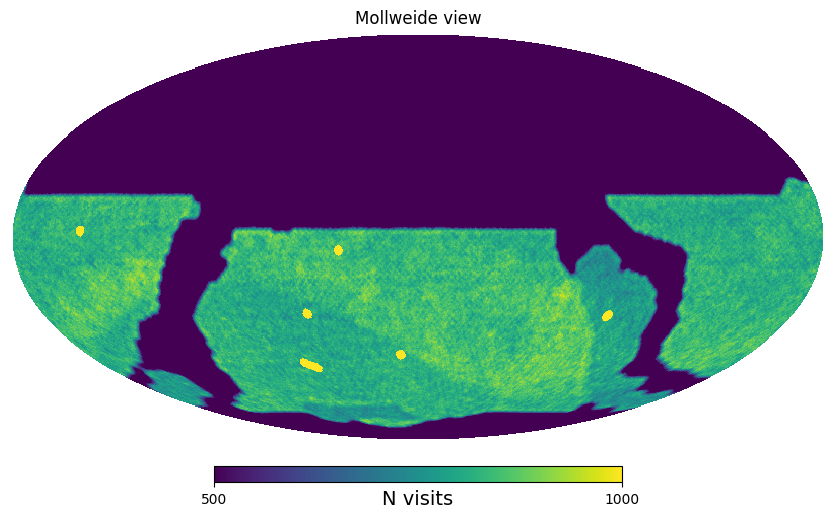

In [ ]:
# Compute the healpy representation of the survey
# with a cut to a minimum of 500 and a maximum of 10000 visits
OpSimSurv.compute_hp_rep(nside=240)

# Plot the healpy configuration
fig = OpSimSurv.plot_hp_rep(min=500, max=1000)

### Estructura y Descripción de Columnas

El dataframe df (alias de OpSimSurv.opsimdf) contiene todas las visitas simuladas.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2048612 entries, 0 to 2048611
Data columns (total 48 columns):
 #   Column               Dtype  
---  ------               -----  
 0   fieldRA              float64
 1   fieldDec             float64
 2   observationStartMJD  float64
 3   flush_by_mjd         float64
 4   visitExposureTime    float64
 5   band                 object 
 6   filter               object 
 7   rotSkyPos            float64
 8   rotSkyPos_desired    float64
 9   numExposures         int64  
 10  airmass              float64
 11  seeingFwhm500        float64
 12  seeingFwhmEff        float64
 13  seeingFwhmGeom       float64
 14  skyBrightness        float64
 15  night                int64  
 16  slewTime             float64
 17  visitTime            float64
 18  slewDistance         float64
 19  fiveSigmaDepth       float64
 20  altitude             float64
 21  azimuth              float64
 22  paraAngle            float64
 23  pseudoParaAngle      float64
 24  clo

La descripcion de cada columna es:

0 fieldRA (float64): Ascensión Recta del centro del campo (en grados).

1 fieldDec (float64): Declinación del centro del campo (en grados).

2 observationStartMJD (float64): Tiempo de inicio de la observación (Modified Julian Date).

3 flush_by_mjd (float64): MJD límite para descargar los datos del buffer.

4 visitExposureTime (float64): Tiempo de exposición de la visita (ej. 15.0 o 30.0 segundos).

5 band (object): Banda observacional (ej. 'u', 'g', 'r', 'i', 'z', 'y').

6 filter (object): Filtro utilizado (coincide con band).

7 rotSkyPos (float64): Posición angular del cielo en el plano focal (rotación).

8 rotSkyPos_desired (float64): Posición angular deseada.

9 numExposures (int64): Número de exposiciones en la visita (generalmente 1 o 2).

10 airmass (float64): Masa de aire (sec(z), donde z es el ángulo cenital).

11 seeingFwhm500 (float64): Seeing (FWHM) atmosférico a 500nm.

12 seeingFwhmEff (float64): Seeing efectivo (FWHM) en la banda observada.

13 seeingFwhmGeom (float64): Seeing geométrico (FWHM) en la banda observada.

14 skyBrightness (float64): Brillo del cielo (mag/arcsec^2).

15 night (int64): Número de la noche de observación (contando desde el inicio del survey).

16 slewTime (float64): Tiempo de apuntado del telescopio (segundos).

17 visitTime (float64): Tiempo total de la visita (exposición + readout).

18 slewDistance (float64): Distancia angular del apuntado (grados).

19 fiveSigmaDepth (float64): Profundidad de la observación (magnitud límite a 5-sigma).

20 altitude (float64): Altitud del campo sobre el horizonte (grados).

21 azimuth (float64): Azimut del campo (grados).

22 paraAngle (float64): Ángulo paraláctico.

23 pseudoParaAngle (float64): Ángulo pseudo-paraláctico.

24 cloud (float64): Nivel de nubosidad (extinción).

25 moonAlt (float64): Altitud de la Luna.

26 sunAlt (float64): Altitud del Sol.

27 scheduler_note (object): Nota del scheduler (ej. 'greedy', 'twilight_near_sun').

28 target_name (object): Nombre del objetivo (ej. 'ELAISS1').

29 target_id (int64): ID numérico del objetivo.

30 observationStartLST (float64): Tiempo Sidéreo Local de inicio de la observación.

31 rotTelPos (float64): Posición de rotación del telescopio.

32 rotTelPos_backup (float64): Posición de rotación de respaldo.

33 moonAz (float64): Azimut de la Luna.

34 sunAz (float64): Azimut del Sol.

35 sunRA (float64): Ascensión Recta del Sol.

36 sunDec (float64): Declinación del Sol.

37 moonRA (float64): Ascensión Recta de la Luna.

38 moonDec (float64): Declinación de la Luna.

39 moonDistance (float64): Distancia angular entre el campo y la Luna.

40 solarElong (float64): Elongación solar.

41 moonPhase (float64): Fase lunar (%).

42 cummTelAz (float64): Azimut acumulado del telescopio.

43 observation_reason (object): Razón de la observación (ej. 'pairs_i_5.0').

44 science_program (object): Programa científico (ej. 'None', 'DD', 'ToO').

45 cloud_extinction (float64): Extinción por nubosidad.

46 _ra (float64): Ascensión Recta (coordenada interna en radianes).

47 _dec (float64): Declinación (coordenada interna en radianes).

Observamos los limites temporales

In [ ]:
# tiempo mínimo
min_t_all = Time(min(df['observationStartMJD']), format='mjd').to_value('ymdhms')

# tiempo máximo
max_t_all = Time(max(df['observationStartMJD']), format='mjd').to_value('ymdhms')

print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))

Observaciones 
 desde: (2025, 11, 1, 0, 2, 20.49224867) 
 hasta: (2035, 11, 1, 6, 32, 59.95004507)


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


##Procesamiento para SIMLIB

El archivo SIMLIB requiere un formato específico y un subconjunto de los datos de OpSim.

### Identificación y Separación de Programas (DDF vs WFD)

El SIMLIB generalmente se crea por separado para los Deep Drilling Fields (DDF) y el Wide-Fast-Deep (WFD).

Se utiliza la columna scheduler_note para identificar los tipos de observación.

In [ ]:
WFD_list = ['blob_long, gr, a', 'blob_long, gr, b', 'pair_33, ug, a',
       'pair_33, ug, b', 'long', 'pair_15, iz, a', 'pair_15, iz, b',
       'pair_15, ri, a', 'pair_15, ri, b', 'pair_15, zy, a',
       'pair_33, gr, a', 'pair_33, gr, b', 'pair_33, ri, a',
       'pair_33, ri, b', 'pair_15, yy, a', 'pair_15, yy, b',
       'pair_33, iz, a', 'pair_33, iz, b', 'pair_15, zy, b',
       'pair_33, zy, a', 'pair_33, zy, b', 'pair_33, yy, a',
       'pair_33, yy, b', 'blob_long, iz, a', 'blob_long, iz, b',
       'pair_33, ur, a', 'pair_33, ur, b', 'blob_long, ri, a',
       'blob_long, ri, b'] #greedy, twilight_near_sun?
twilight_near_sun_list = ['twilight_near_sun, 0', 'twilight_near_sun, 1', 'twilight_near_sun, 2',
       'twilight_near_sun, 3']

conditions = [(df.scheduler_note.isin(WFD_list)),
              (df.scheduler_note.str.startswith('DD:')), # Modified condition for DD
              (df.scheduler_note.isin(twilight_near_sun_list)),
              (df.scheduler_note =='greedy')
             ]
field_types = ['WFD', 'DD', 'twilight_near_sun', 'greedy']
df['field_type'] = np.select(conditions, field_types, default='Other')
df

fieldRA   fieldDec  observationStartMJD  flush_by_mjd  \
observationId                                                             
0              261.567911 -27.431786         60980.001626   60980.02490   
1              262.851107 -22.591159         60980.001877   60980.02490   
2              261.834513 -19.886311         60980.002123   60980.02490   
3              260.885516 -17.164857         60980.002369   60980.02490   
4              262.197819 -12.138795         60980.002619   60980.02490   
...                   ...        ...                  ...           ...   
2048607         70.400259 -72.260546         64632.270857   64632.32233   
2048608         60.692490 -76.403093         64632.271382   64632.32233   
2048609         71.299640 -75.257240         64632.271893   64632.32233   
2048610         83.460458 -76.500274         64632.272404   64632.32233   
2048611         91.655232 -74.421923         64632.272916   64632.32233   

               visitExposureTime band filter   rotSkyPos  rotSkyPos_desired  \
observationId                                                                 
0                           15.0    r      r  336.671299                0.0   
1                           15.0    r      r  339.138048                0.0   
2                           15.0    r      r  340.673287                0.0   
3                           15.0    r      r  342.034908                0.0   
4                           15.0    r      r  344.082520                0.0   
...                          ...  ...    ...         ...                ...   
2048607                     38.0    u      u  296.294115                0.0   
2048608                     38.0    u      u  308.438959                0.0   
2048609                     38.0    u      u  295.879323                0.0   
2048610                     38.0    u      u  281.740836                0.0   
2048611                     38.0    u      u  271.426730                0.0   

               numExposures  ...  moonDistance  solarElong  moonPhase  \
observationId                ...                                        
0                         1  ...     74.272993   44.199760  65.730372   
1                         1  ...     73.388864   44.943838  65.731465   
2                         1  ...     74.537327   43.949916  65.732536   
3                         1  ...     75.688202   43.121464  65.733607   
4                         1  ...     74.981544   44.870040  65.734698   
...                     ...  ...           ...         ...        ...   
2048607                   1  ...     93.999795   90.518505   8.039063   
2048608                   1  ...     90.662758   88.158308   8.043509   
2048609                   1  ...     91.092793   87.889337   8.047836   
2048610                   1  ...     88.680469   85.034698   8.052163   
2048611                   1  ...     89.155222   84.800952   8.056492   

                cummTelAz  observation_reason  science_program  \
observationId                                                    
0             -105.779024         pairs_i_5.0             None   
1             -100.078820         pairs_i_5.0             None   
2              -97.689502         pairs_i_5.0             None   
3              -95.361047         pairs_i_5.0             None   
4              -89.776300         pairs_i_5.0             None   
...                   ...                 ...              ...   
2048607       -174.093535       pairs_ug_33.0             None   
2048608       -170.539405       pairs_ug_33.0             None   
2048609       -174.114775       pairs_ug_33.0             None   
2048610       -177.805729       pairs_ug_33.0             None   
2048611       -181.564948       pairs_ug_33.0             None   

               cloud_extinction       _ra      _dec         field_type  
observationId                                                           
0                           0.0  4.565221 -0.478775  twilig

Observamos cuantos tipos de campos tenemos

<Axes: ylabel='field_type'>

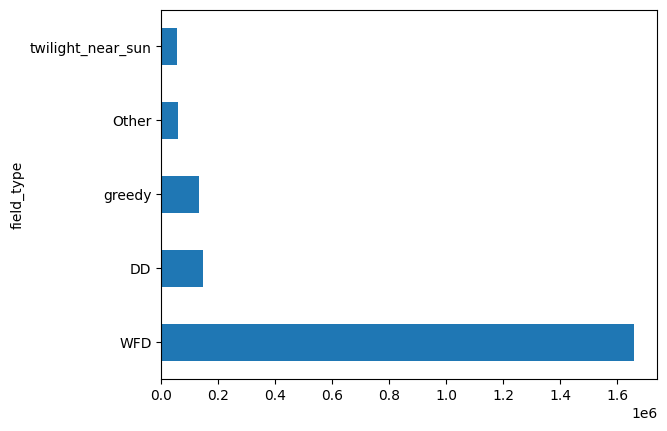

In [ ]:
df.field_type.value_counts().plot.barh()

<Axes: ylabel='observation_reason'>

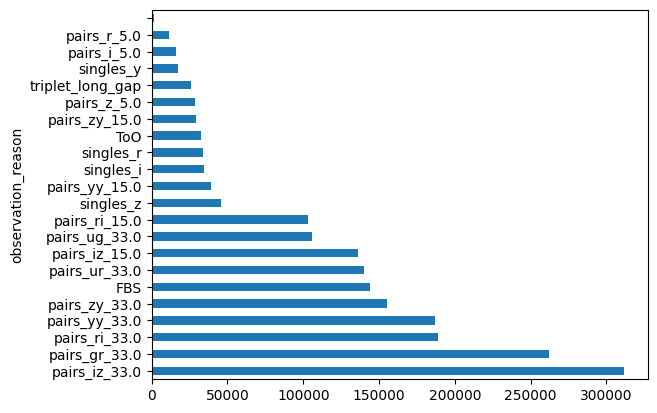

In [ ]:
df.observation_reason.value_counts().plot.barh()

In [ ]:
df_field_type = df[df.field_type == 'Other']
df_field_type

fieldRA   fieldDec  observationStartMJD  flush_by_mjd  \
observationId                                                            
402            26.236749 -75.736118         60980.309329  60980.373885   
403            36.174642 -77.449496         60980.309747  60980.374309   
404            35.819725 -80.610947         60980.310167  60980.374727   
405            35.965945 -83.776534         60980.310587  60980.375147   
406            38.149794 -86.934314         60980.311006  60980.375567   
...                  ...        ...                  ...           ...   
2048345         4.041206 -13.045533         64631.197721  64631.341805   
2048346         0.415458  -9.438198         64631.198149  64631.364722   
2048347         0.954161 -12.206107         64631.198559  64631.364722   
2048348         3.466319 -10.288825         64631.198971  64631.364722   
2048349         4.041206 -13.045533         64631.199382  64631.364722   

               visitExposureTime band filter   rotSkyPos  rotSkyPos_desired  \
observationId                                                                 
402                         30.0    g      g  289.034019                0.0   
403                         30.0    g      g  278.053737                0.0   
404                         30.0    g      g  276.702618                0.0   
405                         30.0    g      g  274.986995                0.0   
406                         30.0    g      g  271.360607                0.0   
...                          ...  ...    ...         ...                ...   
2048345                     29.2    r      r   79.765726                0.0   
2048346                     29.2    r      r   81.578292                0.0   
2048347                     29.2    r      r   79.133338                0.0   
2048348                     29.2    r      r   82.123224                0.0   
2048349                     29.2    r      r   79.481921                0.0   

               numExposures  ...  moonDistance  solarElong  moonPhase  \
observationId                ...                                        
402                       1  ...     72.496436   89.628913  67.438946   
403                       1  ...     75.362698   88.129267  67.442149   
404                       1  ...     77.071668   84.967319  67.445371   
405                       1  ...     78.888105   81.801878  67.448595   
406                       1  ...     80.800652   78.642696  67.451821   
...                     ...  ...           ...         ...        ...   
2048345                   1  ...    140.311954  139.380262   2.885468   
2048346                   1  ...    138.961302  138.722335   2.886468   
2048347                   1  ...    138.140737  137.549755   2.887431   
2048348                   1  ...    141.219566  140.670946   2.888402   
2048349                   1  ...    140.285128  139.378713   2.889374   

                cummTelAz  observation_reason  science_program  \
observationId                                                    
402           -165.296157    triplet_long_gap             None   
403           -168.688925    triplet_long_gap             None   
404           -171.746429    triplet_long_gap             None   
405           -174.729448    triplet_long_gap             None   
406           -177.644666    triplet_long_gap             None   
...                   ...                 ...              ...   
2048345        -69.105455                 ToO             None   
2048346        -67.577049                 ToO             None   
2048347        -70.604342                 ToO             None   
2048348        -65.982818                 ToO             None   
2048349        -69.116427                 ToO             None   

               cloud_extinction       _ra      _dec  field_type  
observationId                                                    
402                         0.0  0.457918 -1.321845       Other  
403                

In [ ]:
df_field_type.scheduler_note.unique()


array(['long, 1', 'long, 2', 'long, 3', ...,
       'ToO, SSO_night, 1326_t1_i2, 3094',
       'ToO, SSO_night, 1326_t1_i2, 3095',
       'ToO, SSO_night, 1326_t1_i2, 3096'], dtype=object)

Agregar estos scheduler_notes a los campos de WDF o DDF segun corersponda si es necesario pero la mayoria corresponde a ToO o a mini surveys diferentes a los campos que queremos estudiar

Se crean dos DataFrames separados: df_DD (para DDF) y df_WFD (para WFD y otros programas principales).

In [ ]:
df_WFD = df[df.field_type=='WFD']
df_WFD

fieldRA   fieldDec  observationStartMJD  flush_by_mjd  \
observationId                                                            
66             26.236749 -75.736118         60980.022490  60980.091054   
67             36.174642 -77.449496         60980.022915  60980.091054   
68             35.819725 -80.610947         60980.023333  60980.091054   
69             35.965945 -83.776534         60980.023751  60980.091054   
70             38.149794 -86.934314         60980.024169  60980.091054   
...                  ...        ...                  ...           ...   
2048607        70.400259 -72.260546         64632.270857  64632.322330   
2048608        60.692490 -76.403093         64632.271382  64632.322330   
2048609        71.299640 -75.257240         64632.271893  64632.322330   
2048610        83.460458 -76.500274         64632.272404  64632.322330   
2048611        91.655232 -74.421923         64632.272916  64632.322330   

               visitExposureTime band filter   rotSkyPos  rotSkyPos_desired  \
observationId                                                                 
66                          30.0    r      r  169.962248                0.0   
67                          30.0    r      r  160.749510                0.0   
68                          30.0    r      r  163.313254                0.0   
69                          30.0    r      r  165.214597                0.0   
70                          30.0    r      r  164.904392                0.0   
...                          ...  ...    ...         ...                ...   
2048607                     38.0    u      u  296.294115                0.0   
2048608                     38.0    u      u  308.438959                0.0   
2048609                     38.0    u      u  295.879323                0.0   
2048610                     38.0    u      u  281.740836                0.0   
2048611                     38.0    u      u  271.426730                0.0   

               numExposures  ...  moonDistance  solarElong  moonPhase  \
observationId                ...                                        
66                        1  ...     71.072959   89.732464  65.821239   
67                        1  ...     73.939679   88.221338  65.823089   
68                        1  ...     75.505016   85.059647  65.824913   
69                        1  ...     77.185652   81.894022  65.826736   
70                        1  ...     78.970408   78.734202  65.828559   
...                     ...  ...           ...         ...        ...   
2048607                   1  ...     93.999795   90.518505   8.039063   
2048608                   1  ...     90.662758   88.158308   8.043509   
2048609                   1  ...     91.092793   87.889337   8.047836   
2048610                   1  ...     88.680469   85.034698   8.052163   
2048611                   1  ...     89.155222   84.800952   8.056492   

                cummTelAz  observation_reason  science_program  \
observationId                                                    
66            -192.545203       pairs_gr_33.0             None   
67            -192.086364       pairs_gr_33.0             None   
68            -188.554563       pairs_gr_33.0             None   
69            -185.192630       pairs_gr_33.0             None   
70            -182.015640       pairs_gr_33.0             None   
...                   ...                 ...              ...   
2048607       -174.093535       pairs_ug_33.0             None   
2048608       -170.539405       pairs_ug_33.0             None   
2048609       -174.114775       pairs_ug_33.0             None   
2048610       -177.805729       pairs_ug_33.0             None   
2048611       -181.564948       pairs_ug_33.0             None   

               cloud_extinction       _ra      _dec  field_type  
observationId                                                    
66                          0.0  0.457918 -1.321845         WFD  
67                 

<Axes: ylabel='observation_reason'>

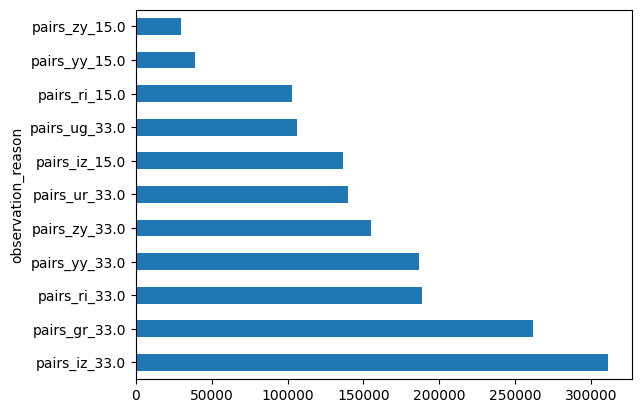

In [ ]:
df_WFD.observation_reason.value_counts().plot.barh()

Las visitas en el WFD suelen obtenerse en pares: la primera y la segunda visita a un apuntamiento están separadas por aproximadamente 33 minutos. Estos pares se obtienen con diferentes filtros, excepto para la banda y: u+g, u+r, g+r, r+i, i+z, z+y, y+y. El uso de diferentes filtros para los pares permite determinar los colores de las variables y los transitorios. Aproximadamente el 3% de todos los pares (4% de todas las visitas) reciben una tercera visita posterior (entre 3 y 7 horas después) con el mismo filtro que una del par anterior. Si bien estos tripletes representan una pequeña fracción del total de visitas, ofrecen valiosas oportunidades para la rápida identificación de transitorios.

En general, cada apunte recibe una visita de retorno entre 2 y 4 días después, cuando se encuentra en una temporada de rotación activa. Las temporadas inactivas tienen una cadencia menor. Estas visitas de retorno suelen realizarse con un conjunto de filtros diferente, pero esto depende de la fase lunar.

Los filtros utilizados dependen de la fase lunar; las bandas U e Y se cargan y descargan en la cámara cada dos semanas. Aproximadamente 7 días después de la luna nueva, se retira el filtro de banda U de la cámara y se instala el de banda Y; este proceso se invierte 7 días antes de la luna nueva.

In [ ]:
df_DD = df[df.field_type=='DD']
df_DD

fieldRA   fieldDec  observationStartMJD  flush_by_mjd  \
observationId                                                            
1178            9.380541 -44.004790         60981.321152  60983.319444   
1179            9.380541 -44.004790         60981.321546  60983.319444   
1180           35.524864  -4.796476         60981.322320  60983.319444   
1181           35.524864  -4.796476         60981.322714  60983.319444   
1182           52.922532 -28.096466         60981.323683  60983.319444   
...                  ...        ...                  ...           ...   
2048573        52.917796 -27.977856         64632.249873  64634.232635   
2048574        52.917796 -27.977856         64632.250361  64634.232635   
2048575        52.917796 -27.977856         64632.250848  64634.232635   
2048576        52.917796 -27.977856         64632.252920  64632.732635   
2048577        52.917796 -27.977856         64632.253314  64632.732635   

               visitExposureTime band filter  rotSkyPos  rotSkyPos_desired  \
observationId                                                                
1178                        30.0    y      y  24.124923                0.0   
1179                        30.0    y      y  24.545956                0.0   
1180                        30.0    y      y  43.238227                0.0   
1181                        30.0    y      y  43.151558                0.0   
1182                        30.0    y      y  21.727346                0.0   
...                          ...  ...    ...        ...                ...   
2048573                     38.0    u      u  53.216819                0.0   
2048574                     38.0    u      u  51.086192                0.0   
2048575                     38.0    u      u  50.646927                0.0   
2048576                     30.0    r      r  50.229606                0.0   
2048577                     30.0    r      r  48.722332                0.0   

               numExposures  ...  moonDistance  solarElong  moonPhase  \
observationId                ...                                        
1178                      1  ...     45.218586  115.938202  74.725098   
1179                      1  ...     45.219859  115.937946  74.728034   
1180                      1  ...     41.468902  160.373947  74.733803   
1181                      1  ...     41.464181  160.373787  74.736747   
1182                      1  ...     62.298057  134.592203  74.743990   
...                     ...  ...           ...         ...        ...   
2048573                   1  ...    139.276550  134.652726   7.860850   
2048574                   1  ...    139.275549  134.652749   7.865007   
2048575                   1  ...    139.274547  134.652771   7.869153   
2048576                   1  ...    139.270249  134.652867   7.886785   
2048577                   1  ...    139.269425  134.652885   7.890140   

                cummTelAz  observation_reason  science_program  \
observationId                                                    
1178          -134.619197                 FBS               DD   
1179          -134.619197                 FBS               DD   
1180           -80.832920                 FBS               DD   
1181           -80.832920                 FBS               DD   
1182          -102.342465                 FBS               DD   
...                   ...                 ...              ...   
2048573        -61.757339                 FBS               DD   
2048574        -61.757339                 FBS               DD   
2048575        -61.757339                 FBS               DD   
2048576        -61.757339                 FBS               DD   
2048577        -61.757339                 FBS               DD   

               cloud_extinction       _ra      _dec  field_type  
observationId                                                    
1178                        0.0  0.163721 -0.768028          DD  
1179                        0.0 

In [ ]:
df_DD.observation_reason.value_counts()


observation_reason
FBS    143867
         1628
Name: count, dtype: int64

<Axes: ylabel='observation_reason'>

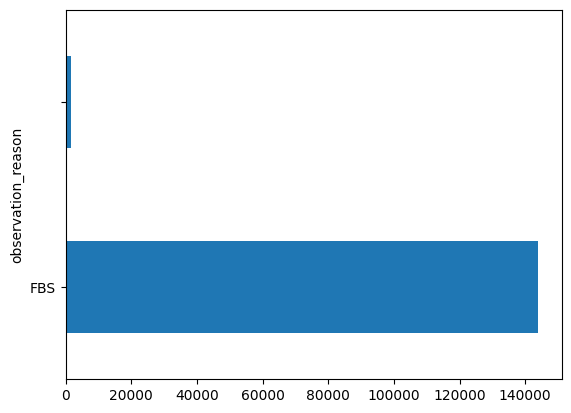

In [ ]:
df_DD.observation_reason.value_counts().plot.barh()

###Creación de BallTree (Búsqueda Espacial)

Para agrupar eficientemente las observaciones por campo (píxel de Healpix), se crean BallTree (árboles de búsqueda espacial) para los conjuntos de datos DDF y WFD.

Estos árboles (DDF_tree y WFD_tree) se construyen usando las coordenadas (_ra, _dec) de las observaciones.

Esto permite, dado un conjunto de coordenadas de "campos" (los hp_rep), encontrar rápidamente todas las observaciones (visitas) que ocurrieron en ese campo.

In [ ]:
OpSimSurv.hp_rep

hp_ra    hp_dec  n_visits field_label
ipix                                            
216975  3.243040  0.381402       507         WFD
216976  3.249585  0.381402       541         WFD
216977  3.256130  0.381402       518         WFD
216978  3.262675  0.381402       518         WFD
216980  3.275765  0.381402       500         WFD
...          ...       ...       ...         ...
685279  0.567232 -1.386825       518         WFD
685280  0.596321 -1.386825       546         WFD
685281  0.625410 -1.386825       530         WFD
685282  0.654498 -1.386825       536         WFD
685283  0.683587 -1.386825       514         WFD

[342729 rows x 4 columns]

In [ ]:
WFD_tree =  BallTree(
            df_WFD[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
        )
DD_tree =  BallTree(
            df_DD[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
        )

In [ ]:
def compute_hp_rep(df, tree=None, nside=256, minVisits=500, maxVisits=None):
    """Compute a healpy version of the survey.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe of OpSim observations.
    tree : sklearn.neighbors.BallTree, optional
        BallTree of the dataframe, by default None. If provided, it will be used to compute the number of visits. Otherwise, the dataframe itself will be used.
    nside : int, optional
        Healpy nside, by default 256
    minVisits : int, optional
        Minimum number of observations required in the survey, by default 500
    maxVisits : int, optional
        Maximum number of observations required in the survey, by default None
    """
    ipix = np.arange(hp.nside2npix(nside))
    hp_ra, hp_dec = np.radians(hp.pix2ang(nside, ipix, lonlat=True))

    hp_rep = pd.DataFrame(dict(ipix=ipix, hp_ra=hp_ra, hp_dec=hp_dec))

    # Compute number of visits
    if tree is not None:
        hp_rep["n_visits"] = tree.query_radius(
            hp_rep[["hp_dec", "hp_ra"]].values,
            r=np.radians(1.75),
            count_only=True,
        )
    else:
        # Compute number of visits directly from the dataframe
        hp_rep["n_visits"] = 0
        for idx, row in df.iterrows():
            pixel_index = hp.ang2pix(nside, np.radians(row['fieldRA']), np.radians(row['fieldDec']), lonlat=True)
            hp_rep.loc[pixel_index, "n_visits"] += 1


    # Apply mask if needed
    visits_mask = np.ones(len(hp_rep), dtype="bool")
    if minVisits is not None:
        visits_mask &= hp_rep["n_visits"] >= minVisits

    if maxVisits is not None:
        visits_mask &= hp_rep["n_visits"] <= maxVisits

    hp_rep = hp_rep[visits_mask]
    hp_rep.set_index("ipix", inplace=True)

    hp_rep.attrs["nside"] = nside
    hp_rep.attrs["survey_area_deg"] = hp.nside2pixarea(
        hp_rep.attrs["nside"], degrees=True
    ) * len(hp_rep)
    hp_rep.attrs["survey_area_rad"] = hp.nside2pixarea(
        hp_rep.attrs["nside"], degrees=False
    ) * len(hp_rep)

    print(
        f"Finished compute healpy representation, total number of fields : {len(hp_rep)}."
    )
    return(hp_rep)

In [ ]:
WFD_hp_rep = compute_hp_rep(df_WFD, WFD_tree,minVisits=250)

Finished compute healpy representation, total number of fields : 406432.


In [ ]:
WFD_hp_rep

hp_ra    hp_dec  n_visits
ipix                                
242703  3.233632  0.392839       251
242704  3.239767  0.392839       263
242705  3.245903  0.392839       279
242706  3.252039  0.392839       282
242707  3.258175  0.392839       261
...          ...       ...       ...
780718  0.311195 -1.401554       254
780719  0.340833 -1.401554       255
780720  0.370471 -1.401554       267
780728  0.607572 -1.401554       255
780729  0.637210 -1.401554       253

[406432 rows x 3 columns]

In [ ]:
DD_hp_rep = compute_hp_rep(df_DD, DD_tree)

Finished compute healpy representation, total number of fields : 1587.


In [ ]:
DD_hp_rep

hp_ra    hp_dec  n_visits
ipix                                
365481  2.607767  0.070371      1197
365482  2.613903  0.070371     11355
365483  2.620039  0.070371     16092
365484  2.626175  0.070371     11908
365485  2.632311  0.070371       654
...          ...       ...       ...
698789  1.033419 -0.891201      2939
698790  1.040934 -0.891201      2502
698791  1.048450 -0.891201      1196
699623  1.023283 -0.894583       585
699624  1.030835 -0.894583       692

[1587 rows x 3 columns]

###Muestreo de Campos (Sampling)

Dado que el WFD completo es muy grande (1658127 registros), a menudo se genera un SIMLIB basado en una muestra representativa de campos.

sample_survey: Se utiliza esta función para seleccionar un número específico de campos (ej. 1000 para DDF, 20000 para WFD) del Healpix representation (hp_rep) calculado anteriormente.

Esto asegura que el SIMLIB final tenga una cobertura de cielo representativa pero un tamaño manejable.

Para el campo DDF son 145495 registros

In [ ]:
def sample_survey(hp_rep, N_fields, random_seed=42, nworkers=10):
    """Sample Nfields inside the survey's healpy representation.

    Parameters
    ----------
    N_fields : int
        Number of fields to sample
    random_seed : int or numpy.random.SeedSquence, optional
        The random  seed used to sample the fields, by default None
    nworkers : int, optional
        Number of cores used to run multiprocessing on host matching, by default 10

    Notes
    ------
    Random seed only apply on field sampling.
    """
    if N_fields > len(hp_rep):
        raise ValueError(
            f"N_fields ({N_fields}) > survey fields ({len(hp_rep)})"
        )

    seed = np.random.SeedSequence(random_seed)
    rng = np.random.default_rng(seed)

    survey = hp_rep.sample(n=N_fields, replace=False, random_state=rng)
    survey.reset_index(inplace=True)
    survey.attrs = hp_rep.attrs.copy()
    survey.attrs["N_fields"] = N_fields
    return survey



Creamos una funcion para realizar un sampleo espacial de manera exploratoria, al momento de realizar las muestras es importante deinir la fomra de como fue sampleado

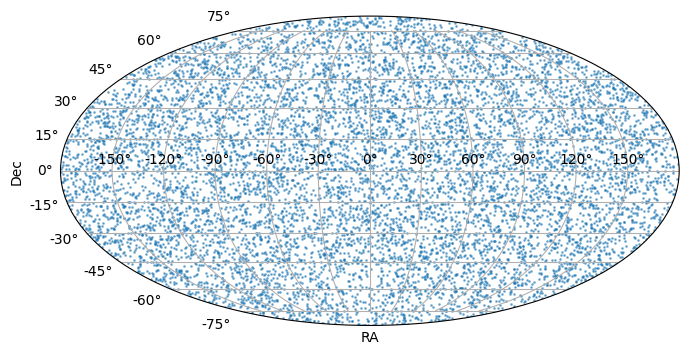

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
rng = np.random.default_rng(42)  # you can use any seed or omit it

def sample_full_sky(n: int, rng: np.random.Generator | None = None) -> SkyCoord:
    """
    Uniform over the full celestial sphere (ICRS).
    Returns SkyCoord with RA in [0, 360) deg and Dec in [-90, 90] deg.
    """
    if rng is None:
        rng = np.random.default_rng()

    # RA uniform in [0, 2π); sin(Dec) uniform in [-1, 1]
    ra = rng.random(n) * 360.0  # deg
    sin_dec = rng.uniform(-1.0, 1.0, size=n)
    dec = np.degrees(np.arcsin(sin_dec))
    return SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame="icrs")

sky = sample_full_sky(10_000, rng=rng)

fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111, projection="mollweide")
# Convert RA to radians in [-π, π], Dec to radians
ra_rad = np.radians((sky.ra.deg + 180.0) % 360.0 - 180.0)
dec_rad = np.radians(sky.dec.deg)
ax.scatter(ra_rad, dec_rad, s=1, alpha=0.5)
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def plot_hp_rep(hp_rep, **hp_mollview_kwargs):
    """Plot the healpy mollview of the survey representation.

    Returns
    -------
    matplotlib.Figure
        The mollview figure
    """
    # Reset the index to access the ipix column
    hp_rep = hp_rep.reset_index()

    ipix_map = np.zeros(hp.nside2npix(hp_rep.attrs["nside"]))
    ipix_map[hp_rep.ipix.values] = hp_rep.n_visits.values
    return hp.mollview(map=ipix_map, unit="N visits", **hp_mollview_kwargs)

In [ ]:
sample_DD = sample_survey(DD_hp_rep,1000)
sample_DD

ipix     hp_ra    hp_dec  n_visits
0    662949  0.136178 -0.757593     21930
1    576149  0.914253 -0.484929     23266
2    434789  0.619728 -0.106975     21020
3    575122  0.898913 -0.481988     23266
4    570003  0.901981 -0.467349     10491
..      ...       ...       ...       ...
995  583313  0.892777 -0.505649      6114
996  414308  0.613592 -0.054715     11904
997  678479  1.079922 -0.812832     14425
998  657931  0.145904 -0.740197      7529
999  689333  1.010308 -0.853864     15415

[1000 rows x 4 columns]

/tmp/ipython-input-1166415175.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_cmap = matplotlib.cm.get_cmap('viridis')


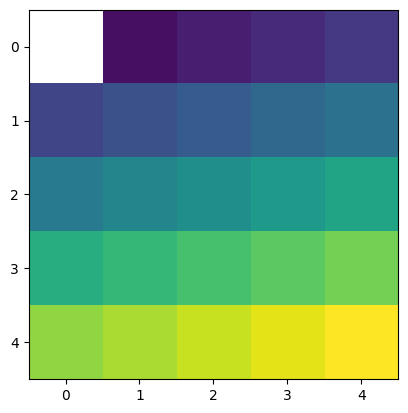

In [ ]:
my_cmap = matplotlib.cm.get_cmap('viridis')
my_cmap.set_under('w')
plt.imshow(np.arange(25).reshape(5, 5),
       interpolation='none',
       cmap=my_cmap,
       vmin=.001)

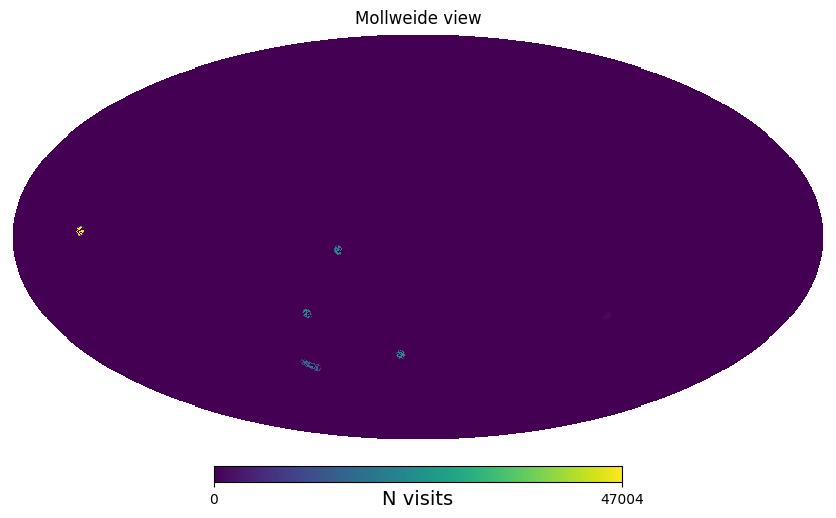

In [ ]:

plot_hp_rep(sample_DD)

In [ ]:
sample_WFD = sample_survey(WFD_hp_rep,20000)
sample_WFD

ipix     hp_ra    hp_dec  n_visits
0      628842  3.795068 -0.642200       719
1      305975  1.908272  0.223203       696
2      528832  5.893554 -0.350907       727
3      476409  4.669438 -0.212534       536
4      483588  4.740001 -0.231221       692
...       ...       ...       ...       ...
19995  518243  3.752117 -0.323312       739
19996  520803  0.607456 -0.331563       710
19997  614912  0.000000 -0.600560       697
19998  669314  3.209747 -0.778382       683
19999  352308  3.463729  0.104356       726

[20000 rows x 4 columns]

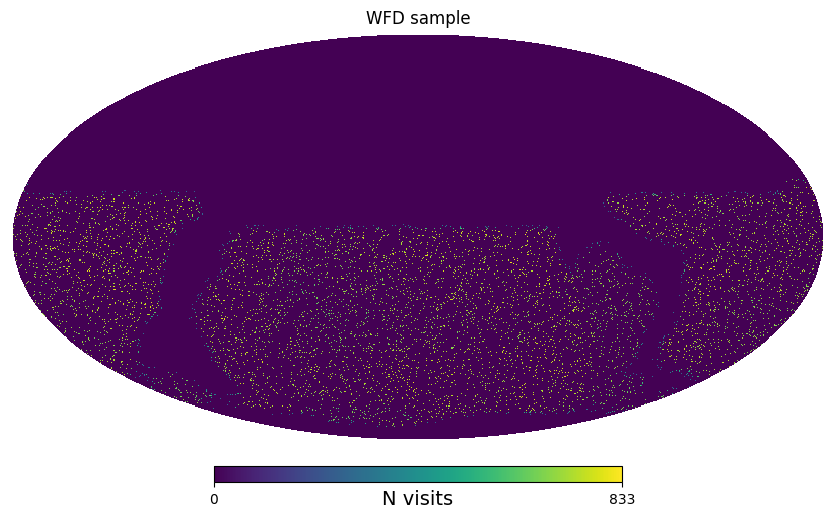

In [ ]:
plot_hp_rep(sample_WFD,title='WFD sample')
plt.savefig('WFD_hp')

In [ ]:
    def formatObs(OpSimObs, keep_keys=[]):
        """Format function to get quantities of interest for simulation.

        Parameters
        ----------
        OpSimObs : pandas.DataFrame
            Dataframe of OpSim output
        keep_keys : list(str)
            List of keys to keep in addition to formatted quantities

        Returns
        -------
        pandas.DataFrame
            Dataframe that contains quantities for simulation.

        Notes
        -----
        Quantities are obtained following arxiv:1905.02887

        Details of the calculs:

        The :math:`\sigma_\mathrm{PSF}` in units of :math:`\mathrm{arcsec}^{-1}` is obtained as

        .. math::
            \sigma_\mathrm{PSF} = \\frac{\mathbf{seeingFwhmEff}}{2\sqrt{2\ln2}}.

        The :math:`\mathbf{PSF}` is computed in units of :math:`\mathrm{pixel}^{-1}` as

        .. math::
            \mathbf{PSF} = \\frac{\sigma_\mathrm{PSF}}{\mathrm{PixelSize}},

        where :math:`\mathrm{PixelSize}` is the pixel size in :math:`\mathrm{arcsec}^{-1}`.

        The zero-point :math:`\mathbf{ZPT}` is computed as

        .. math::
            \mathbf{ZPT} = 2 m_5 - m_\mathrm{sky} + 2.5 \log\left[25 A \left(1 + A^{-1}10^{-0.4(m_5-m_\mathrm{sky})}\\right)\\right],

        where :math:`m_5 = \mathbf{fiveSigmaDepth}`, :math:`m_\mathrm{sky} = \mathbf{skyBrightness}` and :math:`A` is the noise equivalent area given by
        :math:`A = 4 \pi \sigma_\mathrm{PSF}^2`.

        The sky noise :math:`\mathbf{SKYSIG}` in unit of :math:`\mathrm{ADU}.\mathrm{pixel}^{-1}` is computed such as

        .. math::
            \mathbf{SKYSIG}^2 = 10^{-0.4\left(m_\mathrm{sky} - \mathbf{ZPT}\\right)} \\times \mathrm{PixelSize}^2.
        """
        sigPSF = OpSimObs["seeingFwhmEff"] / (2 * np.sqrt(2 * np.log(2)))

        # PSF in pixels^{-1}
        PSF = sigPSF / 0.2  # LSST Pixel size in arcsec^-1

        # Noise Effective Area in arcsec^{-2}
        NoiseArea = 4 * np.pi * sigPSF**2

        # ZPT
        dmag = OpSimObs["fiveSigmaDepth"] - OpSimObs["skyBrightness"]

        ZPT = 2 * OpSimObs["fiveSigmaDepth"] - OpSimObs["skyBrightness"]
        ZPT += 2.5 * np.log10(25 * NoiseArea)
        ZPT += 2.5 * np.log10(1 + 10 ** (-0.4 * dmag) / NoiseArea)

        # SKYSIG
        dskymag = OpSimObs["skyBrightness"] - ZPT
        SKYSIG = np.sqrt(10 ** (-0.4 * dskymag) * 0.2**2)

        formatobs_df = pd.DataFrame(
            {
                "expMJD": OpSimObs["observationStartMJD"],
                "PSF": PSF,
                "ZPT": ZPT,
                "SKYSIG": SKYSIG,
                "BAND": OpSimObs["filter"],
                **{k: OpSimObs[k] for k in keep_keys},
            }
        ).reset_index(names="ObsID")

        return formatobs_df


<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-604722666.py:22: SyntaxWarning: invalid escape sequence '\s'
  The :math:`\sigma_\mathrm{PSF}` in units of :math:`\mathrm{arcsec}^{-1}` is obtained as


In [ ]:
def get_obs_from_coords(tree,df, ra, dec, is_deg=True,formatobs=False, keep_keys=[]):
    """Get observations at ra, dec coordinates.

    Parameters
    ----------
    ra : numpy.ndarray(float)
        RA coordinate
    dec : numpy.ndarray(float)
        Dec coordinate
    is_deg : bool, optional
        is RA, Dec given in degrees, by default True
    formatobs : bool, optional
        format obs for simulation, by default False
    keep_keys : list(str)
        List of keys to keep in addition to formatted quantities

    Yields
    ------
    pandas.DatFrame
        Dataframes of observations.
    """
    if is_deg:
        ra = np.radians(ra)
        dec = np.radians(dec)

    obs_idx = tree.query_radius(
        np.array([dec, ra]).T,
        r=np.radians(1.75),
        count_only=False,
        return_distance=False,
    )
    for idx in obs_idx:
        if formatobs:
            yield formatObs(df.iloc[idx], keep_keys=keep_keys)
        else:
            yield df.iloc[idx]



In [ ]:
def get_survey_obs(tree, df, hp_rep, formatobs=True, keep_keys=[]):
    """Get survey observations.

    Parameters
    ----------
    formatobs : bool, optional
        Format the observation to get only quantities of interest for simulation, by default True
    keep_keys : list(str)
        List of keys to keep in addition to formatted quantities

    Yields
    ------
    pandas.DatFrame
        Dataframes of observations.
    """
    return get_obs_from_coords(
        tree, df, *hp_rep[["hp_ra", "hp_dec"]].values.T,
        is_deg=False,
        formatobs=formatobs,
        keep_keys=keep_keys,
    )

## Cadencia de observacion

### Analisis temporal del plan de observaciones

El **LSST Wide Fast Deep** (WFD) del Observatorio Rubin compone la mayor parte de las visitas del sondeo, utilizando aproximadamente el 80% del tiempo total del mismo. El WFD está diseñado para alcanzar gran parte de los objetivos científicos principales del LSST.

El cielo del WFD incluye una zona de baja extinción de polvo, útil para la ciencia extragaláctica, así como zonas de mayor densidad estelar (con mayor extinción de polvo), útiles para la ciencia galáctica. El área total del WFD es de aproximadamente 19.600 grados cuadrados.

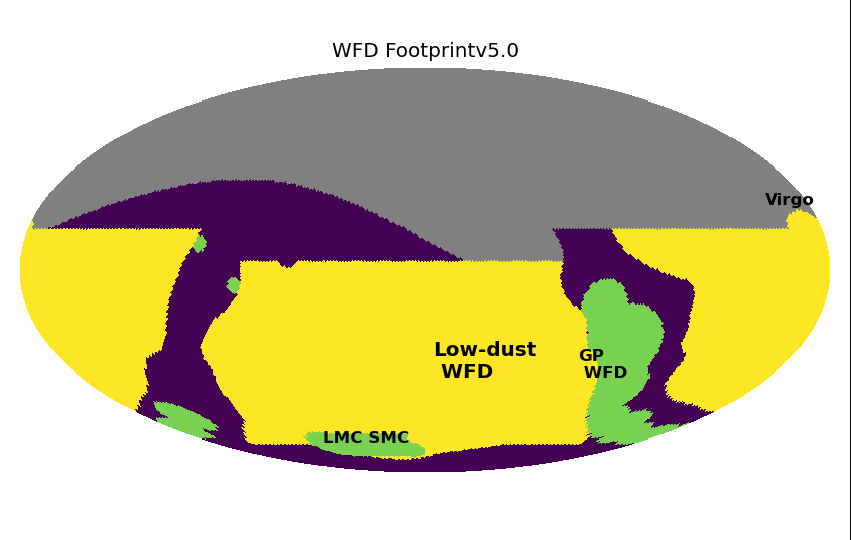


**Cadencia de Visitas del WFD**

Toda el área del WFD recibe aproximadamente el mismo número de visitas por apuntamiento (unas 800), aunque el balance de visitas entre los diferentes filtros varía entre las zonas con baja concentración de polvo y otras.

El WFD con baja concentración de polvo utiliza una cadencia rotativa, alternando áreas de alta y baja actividad en el cielo cada año. No se realiza esta cadencia rotativa en el primer año para proporcionar una cobertura uniforme de todo el cielo en la primera publicación completa de datos, lo que facilita la calibración y la creación del catálogo.

Las visitas en el WFD se obtienen típicamente en pares: la primera y la segunda visita a un apuntamiento están separadas por unos 33 minutos. Estos pares se obtienen con diferentes filtros, excepto para la banda y: u+g, u+r, g+r, r+i, i+z, z+y, y+y. El uso de diferentes filtros para los pares permite determinar los colores de las variables y los transitorios. Aproximadamente el 3% de todos los pares (4% de todas las visitas) reciben una tercera visita posterior (entre 3 y 7 horas después) con el mismo filtro que una del par anterior. Si bien estos tripletes constituyen una pequeña fracción del total de visitas, brindan oportunidades valiosas para una rápida identificación transitoria.

**Cadencia de Rotación del WFD**

Como parte de la cadencia de rotación, las regiones del WFD con bajo contenido de polvo experimentan ciclos de actividad de alta y baja velocidad en estaciones alternas. Durante el primer año, no se realiza ninguna rotación para proporcionar una cobertura más uniforme de todo el cielo en la primera publicación completa de datos que contiene toda la huella del estudio. Al inicio de la rotación, la huella del WFD con bajo contenido de polvo se divide en dos conjuntos de regiones delimitadas por declinación; estas bandas de declinación se configuran en ciclos de alta/baja velocidad en estaciones alternas. Tras un ciclo completo de alta/baja velocidad (o baja/alta velocidad), se ha adquirido el mismo número de visitas en cada región que el que se habría obtenido si se hubiera seguido la cadencia promedio típica durante el mismo período.

En general, cada apuntamiento recibe una visita de retorno entre 2 y 4 días después, durante una temporada de rotación activa. Las temporadas inactivas tienen una cadencia menor. Estas visitas de retorno suelen realizarse con un conjunto de filtros diferente, pero esto depende de la fase lunar.

Los filtros utilizados dependen de la fase lunar; las bandas U e Y se cargan y descargan en la cámara cada dos semanas. Aproximadamente 7 días después de la luna nueva, se retira el filtro de banda U de la cámara y se instala el de banda Y; este proceso se invierte 7 días antes de la luna nueva.


En un LSST de diez años, sin rotación en el primer año y utilizando dos conjuntos de regiones delimitadas por declinación, existe potencialmente tiempo para cuatro ciclos completos (alto/bajo o bajo/alto) antes del final del estudio. Alternativamente, se pueden insertar más temporadas con la cadencia promedio en los años intermedios del estudio, lo que proporciona una cobertura del cielo más uniforme en las publicaciones de datos intermedios en el cuarto y séptimo año, con un total de tres ciclos de rotación a lo largo de la WFD de bajo polvo durante el estudio. Esta segunda opción se ha denominado "rotación uniforme" y se implementa en la línea base actual. La cadencia de rotación de cuatro ciclos aún está en discusión; la decisión del SCOC sobre tres o cuatro ciclos de rotación probablemente se tomará después del inicio de las operaciones, una vez que se comprenda mejor la recuperación del descubrimiento transitorio de escala de tiempo más rápida.

/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1409703 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


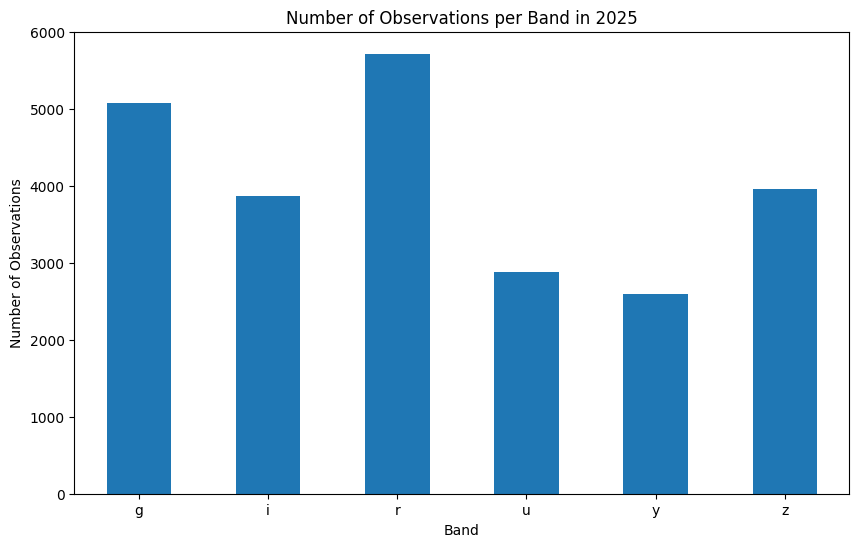

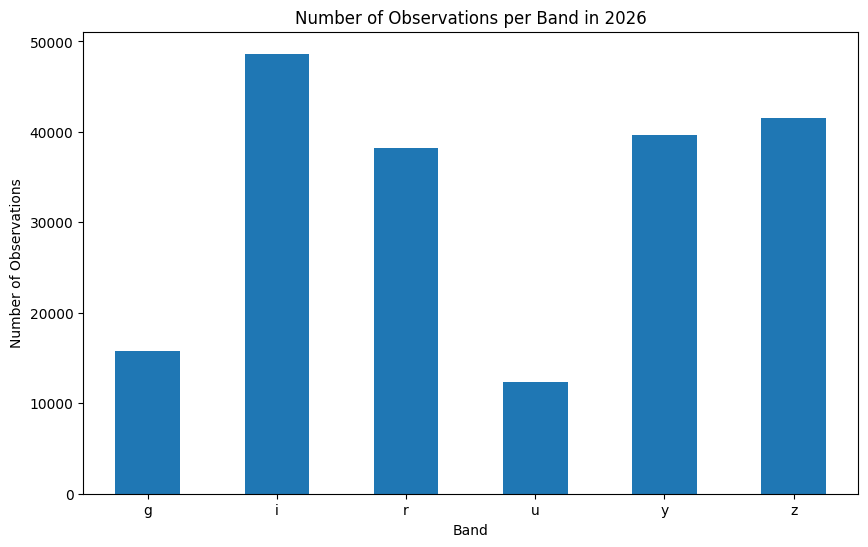

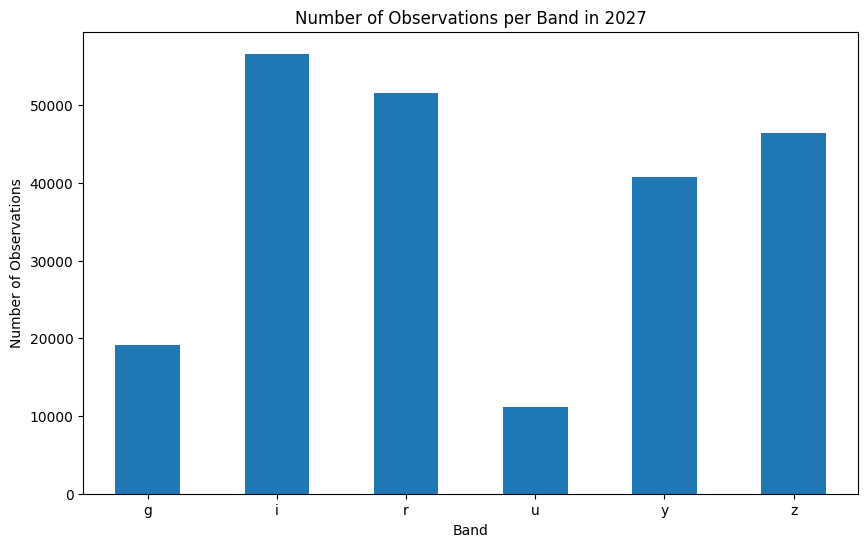

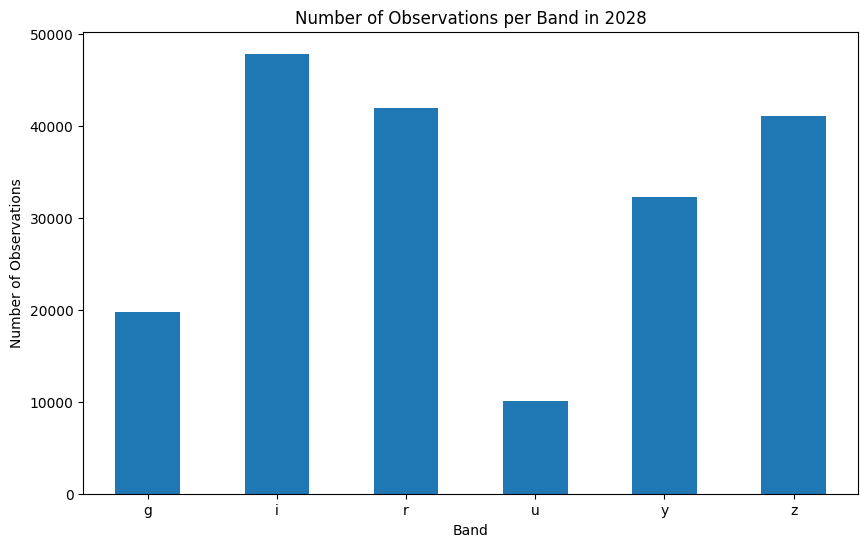

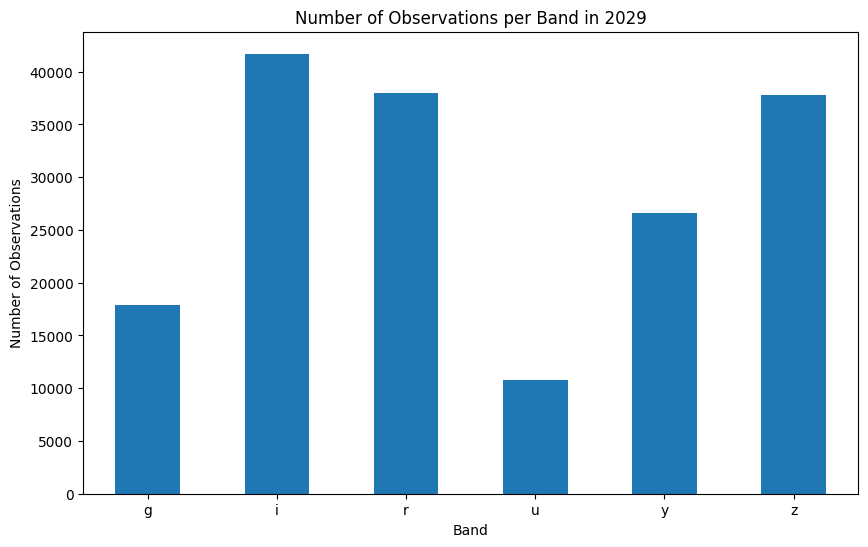

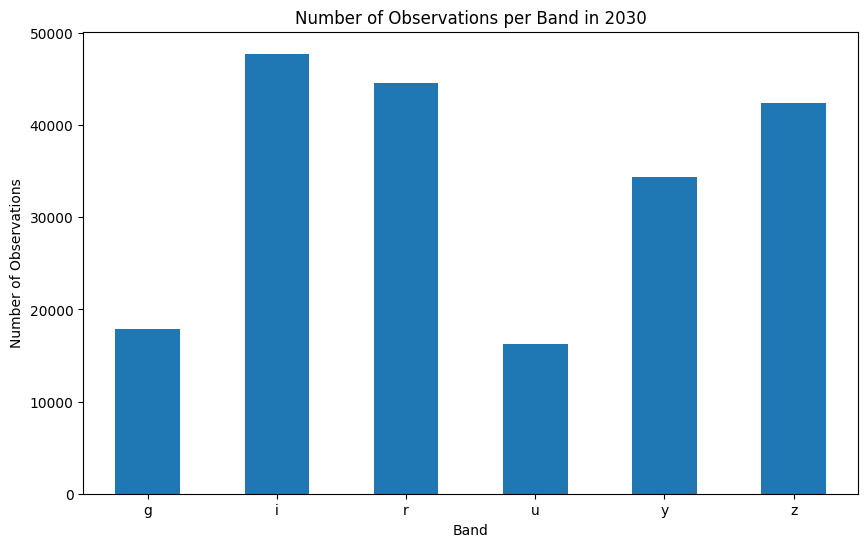

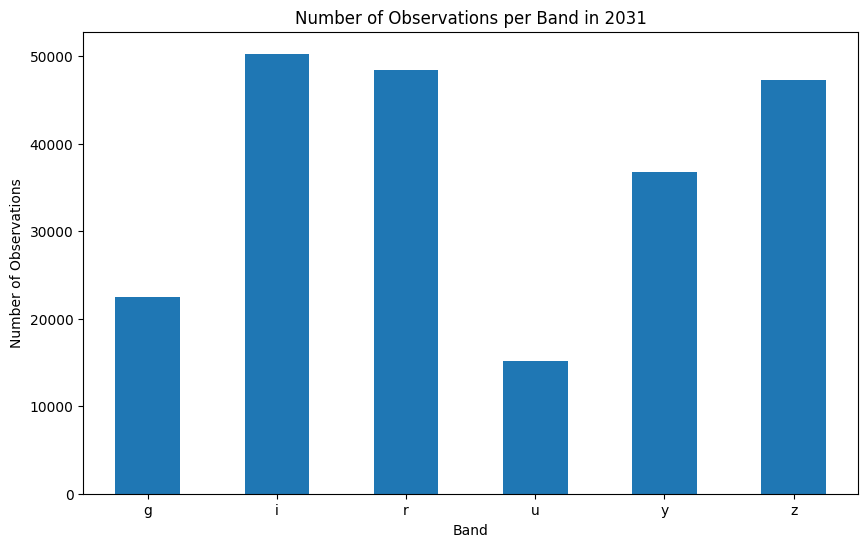

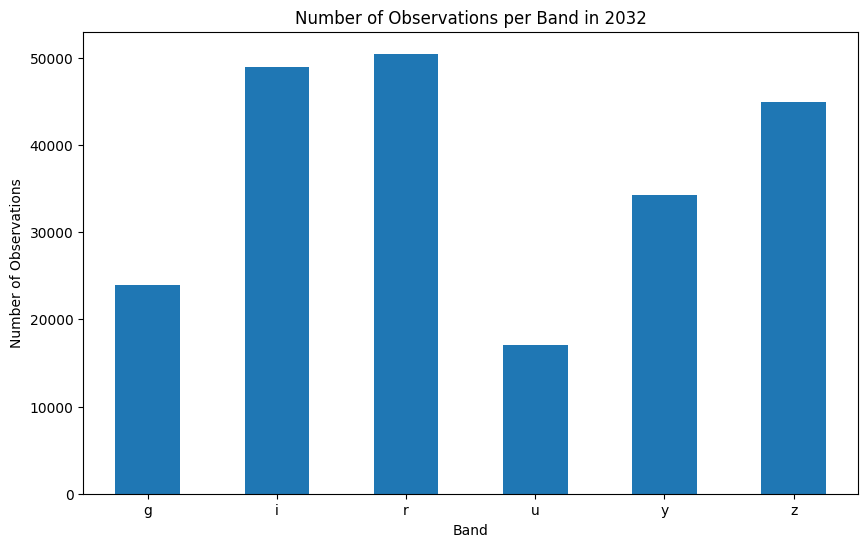

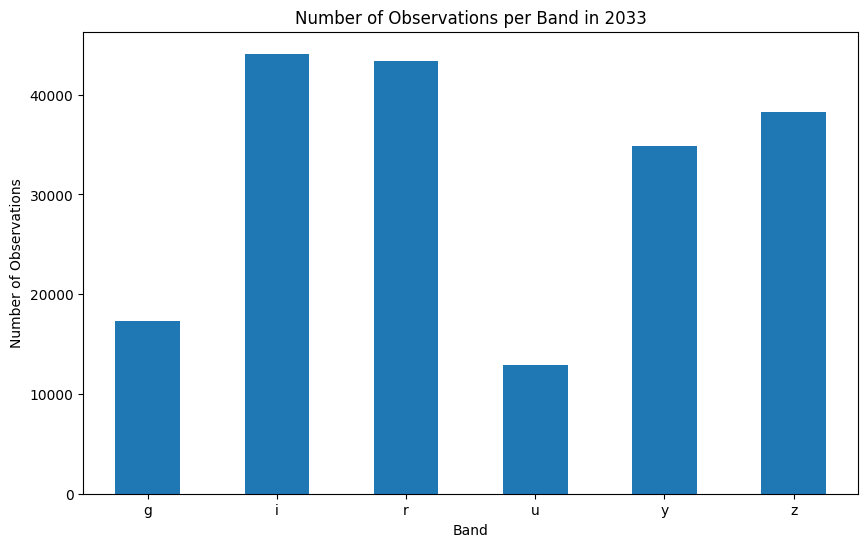

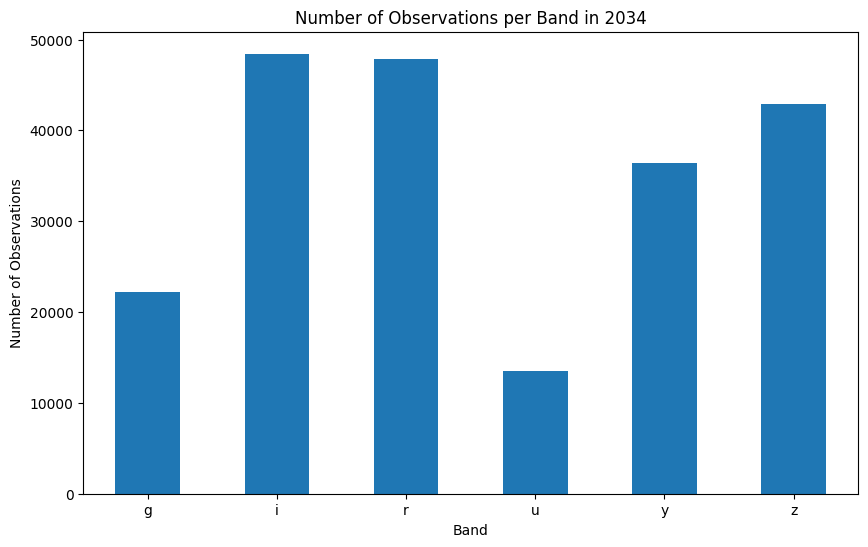

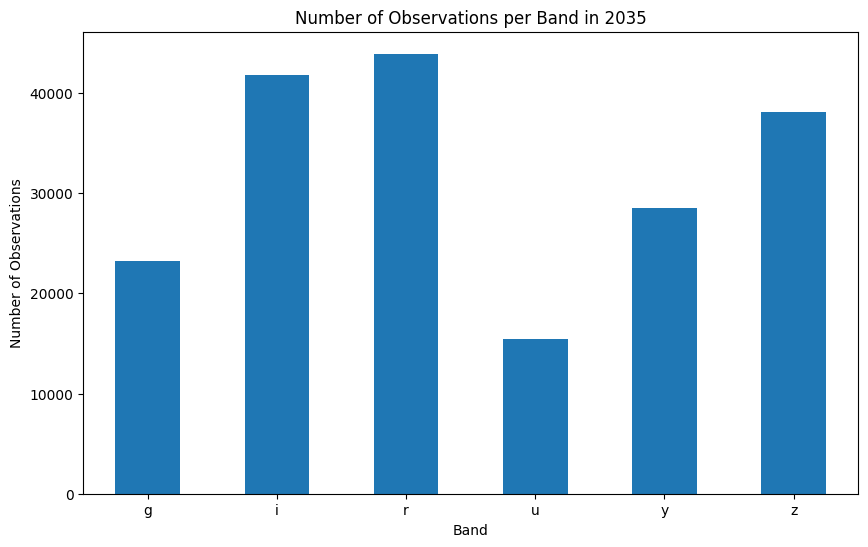

In [ ]:
# Convert MJD to datetime for easier year extraction
df['observation_year'] = pd.Series(Time(df['observationStartMJD'], format='mjd').to_datetime()).dt.year

# Get the range of years in the data
start_year = df['observation_year'].min()
end_year = df['observation_year'].max()

# Create a plot for each year
for year in range(start_year, end_year + 1):
    df_year = df[df['observation_year'] == year]
    if not df_year.empty:
        plt.figure(figsize=(10, 6))
        df_year['band'].value_counts().sort_index().plot(kind='bar')
        plt.title(f'Number of Observations per Band in {year}')
        plt.xlabel('Band')
        plt.ylabel('Number of Observations')
        plt.xticks(rotation=0)
        plt.show()


Para comprender la cadencia y la distribución de las observaciones a lo largo del survey, se realiza un análisis de la cantidad de visitas por año.

Se generan histogramas o gráficos de barras que muestran el número de observaciones en cada banda (u, g, r, i, z, y) por cada año del survey (del año 0 al 9).

Esta visualización permite verificar la consistencia del plan de observación a lo largo del tiempo e identificar los primeros años, que son cruciales para las simulaciones de SN (como SN Ia).

###WFD

Ahora se analizan los mapas de numero de visitas segun cada plan observacional para observar la cadencia de cada plan y como esta disenhado para mejorar las simuaciones

In [ ]:
!pip install --lsst


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --lsst


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize
import skyproj
from lsst.daf.butler import Butler

ModuleNotFoundError: No module named 'lsst'

In [ ]:
# Download necessary data for rubin_sim
!wget https://github.com/lsst/rubin_scheduler/raw/main/rubin_scheduler/site_models/generate_sunsets.py -P /root/rubin_sim_data/site_models/

--2025-10-23 03:27:47--  https://github.com/lsst/rubin_scheduler/raw/main/rubin_scheduler/site_models/generate_sunsets.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lsst/rubin_scheduler/main/rubin_scheduler/site_models/generate_sunsets.py [following]
--2025-10-23 03:27:47--  https://raw.githubusercontent.com/lsst/rubin_scheduler/main/rubin_scheduler/site_models/generate_sunsets.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2276 (2.2K) [text/plain]
Saving to: ‘/root/rubin_sim_data/site_models/generate_sunsets.py’

generate_sunsets.py 100%[===================>]   2.22K  --.-KB/s    in 0s

In [ ]:
import os
os.environ["RUBIN_SIM_DATA"] = "/root/rubin_sim_data"

El código de a continuacion configura y visualiza las divisiones del survey WFD (Wide-Fast-Deep) según el plan de observación de "rolling footprint". Aquí está una explicación detallada:

1.  **Configuración inicial**: Se definen parámetros clave para la simulación, como el `nside` para la representación Healpix, el MJD de inicio del survey, el número de "slices" para la rotación, la escala de la rotación y el número de ciclos.
2.  **Posición del Sol**: Se utiliza la clase `Almanac` de `rubin_sim.site_models` para calcular la posición del Sol (`sun_ra_start`) al inicio del survey. Esto es importante para definir las regiones del cielo que son observables en diferentes momentos.
3.  **Mapa del Cielo y Footprints**: Se crea un objeto `CurrentAreaMap` para obtener un mapa del cielo en la representación Healpix (`footprints_hp_array`) y las etiquetas asociadas a diferentes regiones (`labels`).
4.  **Footprint del WFD**: Se identifica el índice de las regiones que corresponden al WFD (áreas de bajo polvo y Virgo) y se crea un "footprint" binario para el WFD.
5.  **Creación de Footprints Rotativos**: La función `make_rolling_footprints` toma los "footprints" iniciales y los parámetros de rotación para generar una lista de objetos `Footprint`. Cada objeto en esta lista representa el "footprint" del survey en un período específico del ciclo de rotación.
6.  **Visualización**: Se itera sobre la lista de "footprints" generados. Para cada "footprint" de un período, se extrae la información de visitas para la banda 'r' (índice 2) y se utiliza `hp.mollview` para crear una visualización en proyección Mollweide, mostrando la cobertura del cielo para ese período. El título de cada gráfico indica el índice del período de rotación.

Esta visualización ayuda a entender cómo el plan de observación "rolling footprint" distribuye las visitas en diferentes regiones del cielo a lo largo del tiempo.

In [ ]:
from astropy import coordinates as coord
from astropy.time import Time

# Vera Rubin Coordinates from https://www.lsst.org/scientists/keynumbers
rubin_obs = coord.EarthLocation(
    lat='-30:14:40.68', lon='-70:44:57.90', height=2647 * u.m)

# Define time in UTC here
time = Time("2023-04-25T17:00:00", format="isot", scale="utc")

# Some calculations
sun_coordinates = coord.get_sun(time)
sun_coordinates.location = rubin_obs
where_sun = "setting" if (sun_coordinates.altaz.az.value > 180) else "rising"

# Print results
print(f" The azimuth of the {where_sun} Sun at {time} is {sun_coordinates.altaz.az.value:.2f} deg \n"
      f" The elevation of the Sun at {time} is {sun_coordinates.altaz.alt.value:.2f} deg")

 The azimuth of the setting Sun at 2023-04-25T17:00:00.000 is 353.30 deg 
 The elevation of the Sun at 2023-04-25T17:00:00.000 is 46.25 deg


In [ ]:
import os
os.environ["RUBIN_SIM_DATA"] = "/root/rubin_sim_data"

# code snippet to set up baseline survey footprint.
nside = 32
survey_start_mjd = SURVEY_START_MJD
nslice = 2
rolling_scale = 0.9
n_cycles = 3

# Use the Almanac to find the position of the sun at the start of survey
almanac = Almanac(mjd_start=survey_start_mjd)
sun_moon_info = almanac.get_sun_moon_positions(survey_start_mjd)
sun_ra_start = sun_moon_info["sun_RA"].copy()


sky = CurrentAreaMap(nside=nside)
footprints_hp_array, labels = sky.return_maps()

wfd_indx = np.where((labels == "lowdust") | (labels == "virgo"))[0]
wfd_footprint = footprints_hp_array["r"] * 0
wfd_footprint[wfd_indx] = 1

footprints_hp = {}
for key in footprints_hp_array.dtype.names:
    footprints_hp[key] = footprints_hp_array[key]

footprints = make_rolling_footprints(
        fp_hp=footprints_hp,
        mjd_start=survey_start_mjd,
        sun_ra_start=sun_ra_start,
        nslice=nslice,
        scale=rolling_scale,
        nside=nside,
        wfd_indx=wfd_indx,
        order_roll=1,
        n_cycles=n_cycles,
        uniform=True,
    )
for i, footprint in enumerate(footprints.footprint_list):
    # Using index 2 for r band.
    hp.mollview(footprint.footprints[2,:], title=i)

FileNotFoundError: [Errno 2] No such file or directory: '/root/rubin_sim_data/site_models/sunsets.npz'

MJD de inicio de TODO el survey: 60980.00162606769

Seleccionando WFD Periodo 1 (Mask: 2025-2026) (MJD 60980.00 a 61406.00)
Finished compute healpy representation, total number of fields : 533027.
Observaciones 
 desde: (2025, 11, 1, 0, 32, 23.17414379) 
 hasta: (2026, 12, 31, 8, 26, 19.75210031)


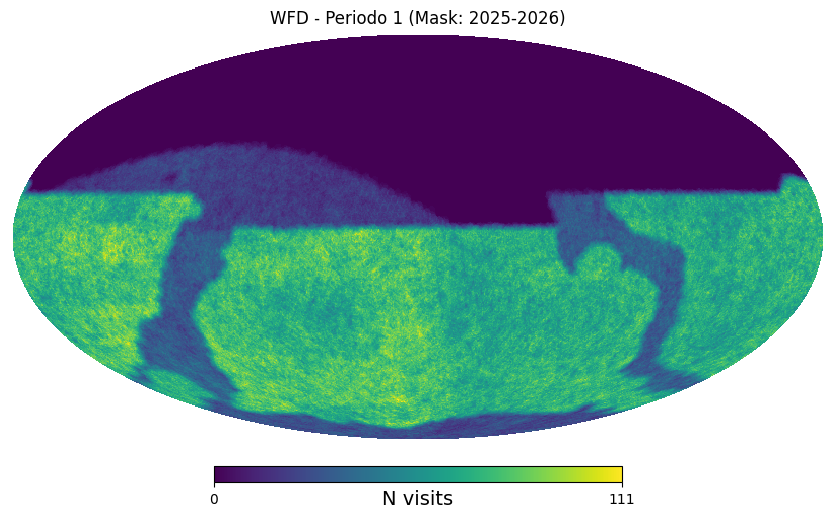

In [ ]:
# 1. OBTÉN EL INICIO ABSOLUTO UNA SOLA VEZ
MJD_inicio_total = df['observationStartMJD'].min()
print(f"MJD de inicio de TODO el survey: {MJD_inicio_total}")

# Calculate MJD for January 1st, 2027
start_date_2027 = Time('2027-01-01', format='iso', scale='utc')
mjd_2027_jan1 = start_date_2027.mjd

# First period: Mask (all of 2025 and 2026) for WFD data
year_start_mjd = MJD_inicio_total
year_end_mjd = mjd_2027_jan1

print(f"\nSeleccionando WFD Periodo 1 (Mask: 2025-2026) (MJD {year_start_mjd:.2f} a {year_end_mjd:.2f})")

df_WFD_Period1 = df_WFD[(df_WFD['observationStartMJD'] >= year_start_mjd) &
                       (df_WFD['observationStartMJD'] < year_end_mjd)].copy()

if not df_WFD_Period1.empty:
    WFD_tree_Period1 = BallTree(
        df_WFD_Period1[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    WFD_Period1_hp_rep = compute_hp_rep(df_WFD_Period1, WFD_tree_Period1, minVisits=1)
    plot_hp_rep(WFD_Period1_hp_rep, title='WFD - Periodo 1 (Mask: 2025-2026)')
    min_t_all = Time(min(df_WFD_Period1['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_WFD_Period1['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WFD Periodo 1 (Mask: 2025-2026).")

# Update current_start_mjd for the next period to be used in subsequent cells
current_start_mjd_WFD = year_end_mjd

El primer anho se usa una mascara uniforme para tener una mejor representacion inicial de las visualizaciones


Seleccionando WFD Periodo 2 (MJD 61406.00 a 61951.50)
Finished compute healpy representation, total number of fields : 531488.
Observaciones 
 desde: (2027, 1, 1, 0, 50, 8.12941398) 
 hasta: (2028, 6, 25, 10, 26, 18.13743982)


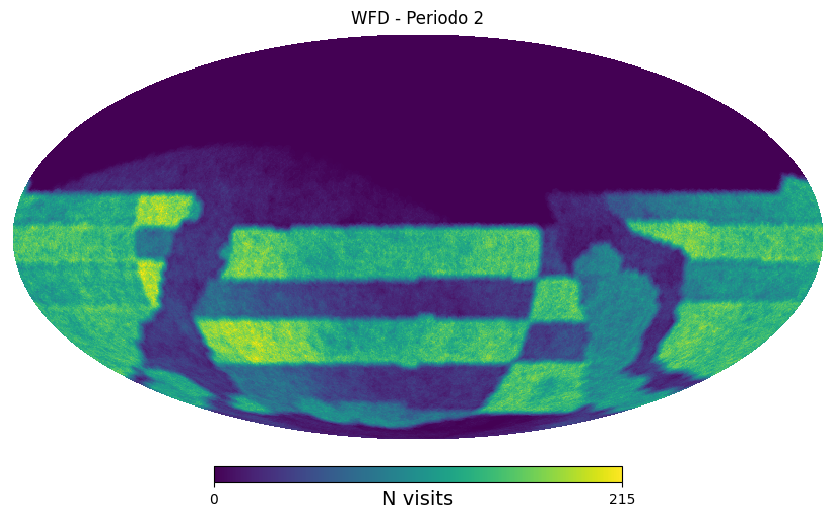

In [ ]:
# Period 2 for WFD: 545.5 days from the end of Period 1
year_index = 2
year_start_mjd = current_start_mjd_WFD
year_end_mjd = current_start_mjd_WFD + 545.5

print(f"\nSeleccionando WFD Periodo {year_index} (MJD {year_start_mjd:.2f} a {year_end_mjd:.2f})")

df_WFD_Period2 = df_WFD[(df_WFD['observationStartMJD'] >= year_start_mjd) &
                       (df_WFD['observationStartMJD'] < year_end_mjd)].copy()

if not df_WFD_Period2.empty:
    WFD_tree_Period2 = BallTree(
        df_WFD_Period2[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    WFD_Period2_hp_rep = compute_hp_rep(df_WFD_Period2, WFD_tree_Period2, minVisits=1)
    plot_hp_rep(WFD_Period2_hp_rep, title=f'WFD - Periodo {year_index}')
    min_t_all = Time(min(df_WFD_Period2['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_WFD_Period2['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WDF Periodo {year_index}.")

# Update current_start_mjd_WFD for the next period
current_start_mjd_WFD = year_end_mjd


Seleccionando WFD Periodo 3 (MJD 61951.500 a 62497.00)
Finished compute healpy representation, total number of fields : 531818.


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Observaciones 
 desde: (2028, 7, 4, 22, 52, 17.59347154) 
 hasta: (2029, 12, 26, 5, 41, 15.73220262)


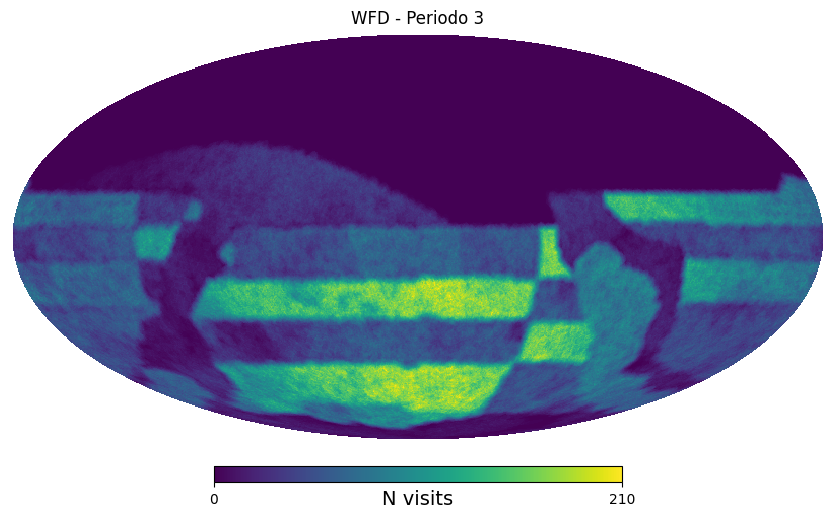

In [ ]:
# Period 3 for WFD: 545.5 days from the end of Period 1
year_index = 3
year_start_mjd = current_start_mjd_WFD
year_end_mjd = current_start_mjd_WFD + 545.5

print(f"\nSeleccionando WFD Periodo {year_index} (MJD {year_start_mjd:.3f} a {year_end_mjd:.2f})")

df_WFD_Period3 = df_WFD[(df_WFD['observationStartMJD'] >= year_start_mjd) &
                       (df_WFD['observationStartMJD'] < year_end_mjd)].copy()

if not df_WFD_Period3.empty:
    WFD_tree_Period3 = BallTree(
        df_WFD_Period3[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    WFD_Period3_hp_rep = compute_hp_rep(df_WFD_Period3, WFD_tree_Period3, minVisits=1)
    plot_hp_rep(WFD_Period3_hp_rep, title=f'WFD - Periodo {year_index}')
    min_t_all = Time(min(df_WFD_Period3['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_WFD_Period3['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WFD Periodo {year_index}.")

# Update current_start_mjd_WFD for the next period
current_start_mjd_WFD = year_end_mjd

Ahora vemos temporada 4


Seleccionando WFD Periodo 4 (MJD 62497.000 a 63042.50)
Finished compute healpy representation, total number of fields : 532275.


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Observaciones 
 desde: (2029, 12, 27, 0, 48, 29.1911223) 
 hasta: (2031, 6, 25, 10, 26, 27.27903301)


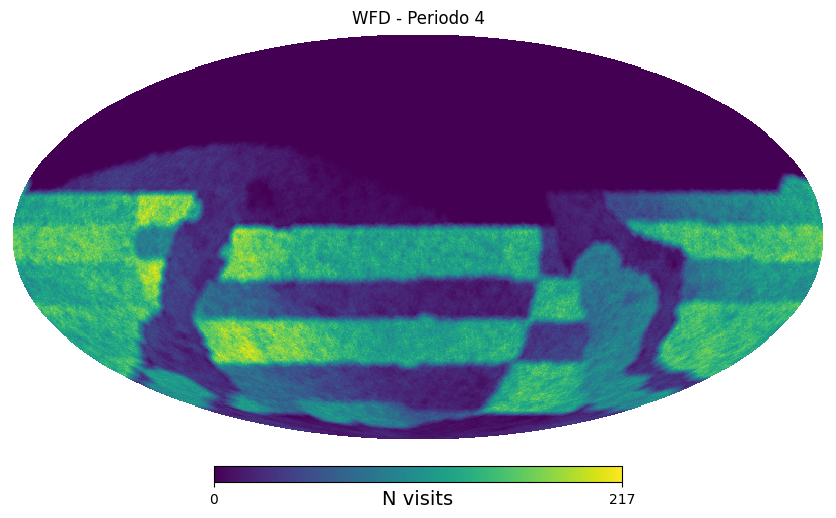

In [ ]:
# Period 4 for WFD: 545.5 days from the end of Period 1
year_index = 4
year_start_mjd = current_start_mjd_WFD
year_end_mjd = current_start_mjd_WFD + 545.5

print(f"\nSeleccionando WFD Periodo {year_index} (MJD {year_start_mjd:.3f} a {year_end_mjd:.2f})")

df_WFD_Period4 = df_WFD[(df_WFD['observationStartMJD'] >= year_start_mjd) &
                       (df_WFD['observationStartMJD'] < year_end_mjd)].copy()

if not df_WFD_Period4.empty:
    WFD_tree_Period4 = BallTree(
        df_WFD_Period4[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    WFD_Period4_hp_rep = compute_hp_rep(df_WFD_Period4, WFD_tree_Period4, minVisits=1)
    plot_hp_rep(WFD_Period4_hp_rep, title=f'WFD - Periodo {year_index}')
    min_t_all = Time(min(df_WFD_Period4['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_WFD_Period4['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WFD Periodo {year_index}.")

# Update current_start_mjd_WFD for the next period
current_start_mjd_WFD = year_end_mjd


Seleccionando WFD Periodo 5 (MJD 63042.500 a 63588.00)
Finished compute healpy representation, total number of fields : 534362.


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Observaciones 
 desde: (2031, 6, 25, 22, 49, 1.66539274) 
 hasta: (2032, 12, 21, 8, 18, 19.69222366)


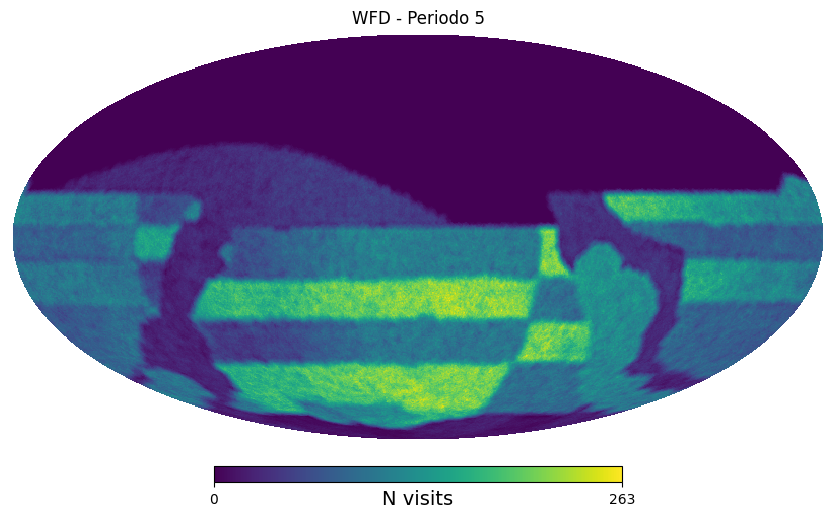

In [ ]:
# Period 5 for WFD: 545.5 days from the end of Period 1
year_index = 5
year_start_mjd = current_start_mjd_WFD
year_end_mjd = current_start_mjd_WFD + 545.5

print(f"\nSeleccionando WFD Periodo {year_index} (MJD {year_start_mjd:.3f} a {year_end_mjd:.2f})")

df_WFD_Period5 = df_WFD[(df_WFD['observationStartMJD'] >= year_start_mjd) &
                       (df_WFD['observationStartMJD'] < year_end_mjd)].copy()

if not df_WFD_Period5.empty:
    WFD_tree_Period5 = BallTree(
        df_WFD_Period5[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    WFD_Period5_hp_rep = compute_hp_rep(df_WFD_Period5, WFD_tree_Period5, minVisits=1)
    plot_hp_rep(WFD_Period5_hp_rep, title=f'WFD - Periodo {year_index}')
    min_t_all = Time(min(df_WFD_Period5['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_WFD_Period5['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WFD Periodo {year_index}.")

# Update current_start_mjd_WFD for the next period
current_start_mjd_WFD = year_end_mjd


Seleccionando WFD Periodo 6 (MJD 63588.000 a 64133.50)
Finished compute healpy representation, total number of fields : 533479.


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Observaciones 
 desde: (2032, 12, 22, 1, 38, 24.95269387) 
 hasta: (2034, 6, 19, 4, 42, 5.0062013)


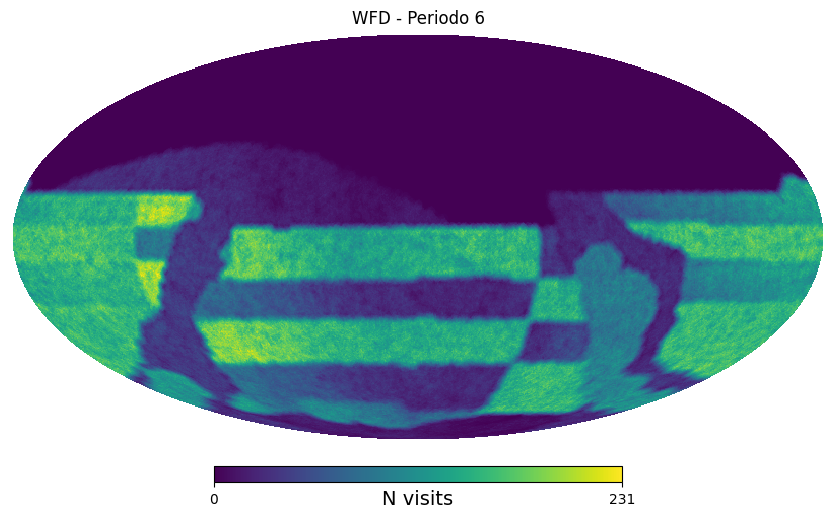

In [ ]:
# Period 6 for WFD: 545.5 days from the end of Period 1
year_index = 6
year_start_mjd = current_start_mjd_WFD
year_end_mjd = current_start_mjd_WFD + 545.5

print(f"\nSeleccionando WFD Periodo {year_index} (MJD {year_start_mjd:.3f} a {year_end_mjd:.2f})")

df_WFD_Period6 = df_WFD[(df_WFD['observationStartMJD'] >= year_start_mjd) &
                       (df_WFD['observationStartMJD'] < year_end_mjd)].copy()

if not df_WFD_Period6.empty:
    WFD_tree_Period6 = BallTree(
        df_WFD_Period6[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    WFD_Period6_hp_rep = compute_hp_rep(df_WFD_Period6, WFD_tree_Period6, minVisits=1)
    plot_hp_rep(WFD_Period6_hp_rep, title=f'WFD - Periodo {year_index}')
    min_t_all = Time(min(df_WFD_Period6['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_WFD_Period6['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WFD Periodo {year_index}.")

# Update current_start_mjd_WFD for the next period
current_start_mjd_WFD = year_end_mjd


Seleccionando WFD Periodo 7 (MJD 64133.500 a 64679.00)
Finished compute healpy representation, total number of fields : 534200.


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Observaciones 
 desde: (2034, 6, 22, 23, 18, 4.57602875) 
 hasta: (2035, 11, 1, 6, 32, 59.95004507)


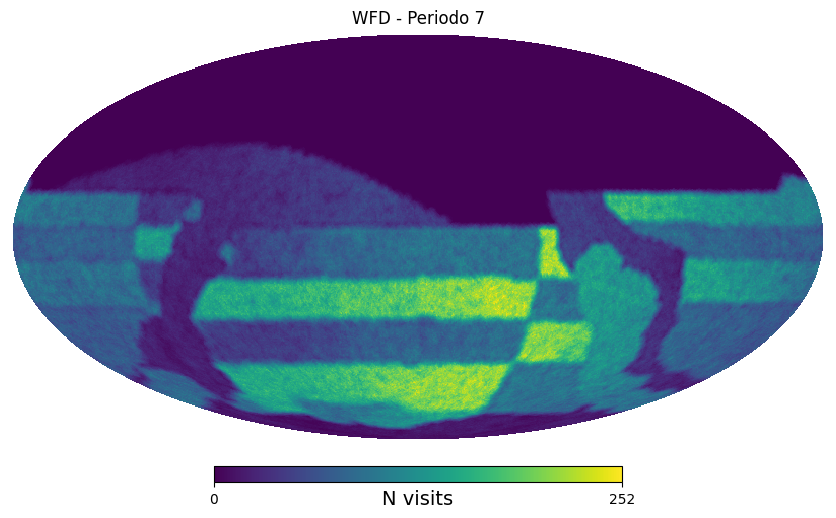

In [ ]:
# Period 7 for WFD: 545.5 days from the end of Period 1
year_index = 7
year_start_mjd = current_start_mjd_WFD
year_end_mjd = current_start_mjd_WFD + 545.5

print(f"\nSeleccionando WFD Periodo {year_index} (MJD {year_start_mjd:.3f} a {year_end_mjd:.2f})")

df_WFD_Period7 = df_WFD[(df_WFD['observationStartMJD'] >= year_start_mjd) &
                       (df_WFD['observationStartMJD'] < year_end_mjd)].copy()

if not df_WFD_Period7.empty:
    WFD_tree_Period7 = BallTree(
        df_WFD_Period7[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    WFD_Period7_hp_rep = compute_hp_rep(df_WFD_Period7, WFD_tree_Period7, minVisits=1)
    plot_hp_rep(WFD_Period7_hp_rep, title=f'WFD - Periodo {year_index}')
    min_t_all = Time(min(df_WFD_Period7['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_WFD_Period7['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WFDF Periodo {year_index}.")

# Update current_start_mjd_WFD for the next period
current_start_mjd_WFD = year_end_mjd

###DDF

El programa de Campos de Perforación Profunda LSST del Observatorio Rubin incluye cinco campos DDF, seleccionados para maximizar la cobertura multilongitud de onda con estudios preexistentes. Uno de los apuntamientos, el Campo Profundo Euclid Sur (EDFS), es un campo más grande y, por lo tanto, se divide entre un apuntamiento "a" y uno "b", que comparten las visitas del DDF.

Los DDF utilizan aproximadamente el 6,5 % del tiempo total del estudio. Cada DDF recibe alrededor de 20 000 visitas, excepto COSMOS, que recibe aproximadamente el doble. El campo COSMOS ha sido seleccionado para recibir cobertura adicional, con el fin de alcanzar la profundidad de 10 años del DDF dentro de los primeros tres años del estudio, como un precursor para el procesamiento de la gestión de datos y las oportunidades científicas.

La cadencia de las visitas del DDF aún está en desarrollo.

MJD de inicio de TODO el survey: 60980.00162606769

Seleccionando DDF Periodo 1 (Mask: 2025-2026) (MJD 60980.00 a 61406.00)
Finished compute healpy representation, total number of fields : 1410.
Observaciones 
 desde: (2025, 11, 2, 7, 42, 27.53178321) 
 hasta: (2026, 12, 31, 7, 50, 18.88550862)


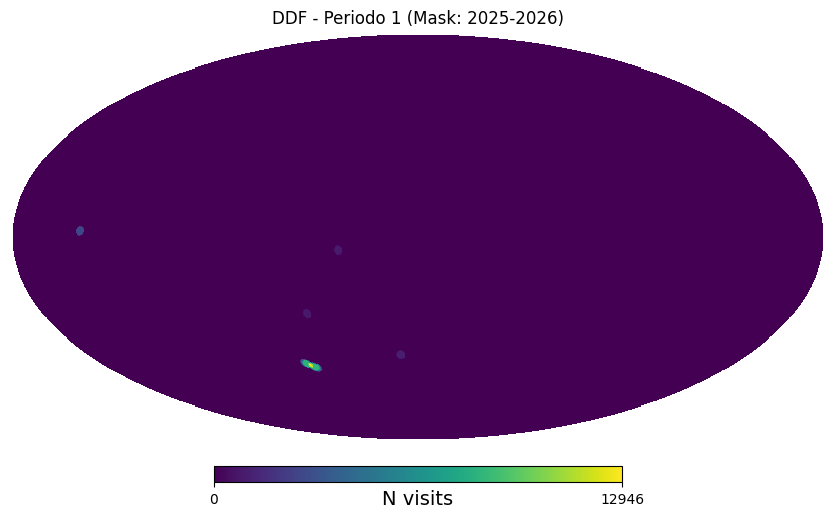

In [ ]:
# 1. OBTÉN EL INICIO ABSOLUTO UNA SOLA VEZ
MJD_inicio_total = df['observationStartMJD'].min()
print(f"MJD de inicio de TODO el survey: {MJD_inicio_total}")

# Calculate MJD for January 1st, 2027
start_date_2027 = Time('2027-01-01', format='iso', scale='utc')
mjd_2027_jan1 = start_date_2027.mjd

# First period: Mask (all of 2025 and 2026) for WFD data
year_start_mjd = MJD_inicio_total
year_end_mjd = mjd_2027_jan1

print(f"\nSeleccionando DDF Periodo 1 (Mask: 2025-2026) (MJD {year_start_mjd:.2f} a {year_end_mjd:.2f})")

df_DDF_Period1 = df_DD[(df_DD['observationStartMJD'] >= year_start_mjd) &
                       (df_DD['observationStartMJD'] < year_end_mjd)].copy()

if not df_DDF_Period1.empty:
    DDF_tree_Period1 = BallTree(
        df_DDF_Period1[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    DDF_Period1_hp_rep = compute_hp_rep(df_DDF_Period1, DDF_tree_Period1, minVisits=1)
    plot_hp_rep(DDF_Period1_hp_rep, title='DDF - Periodo 1 (Mask: 2025-2026)')
    min_t_all = Time(min(df_DDF_Period1['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_DDF_Period1['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el DDF Periodo 1 (Mask: 2025-2026).")
# Update current_start_mjd for the next period to be used in subsequent cells
current_start_mjd_DDF = year_end_mjd


Seleccionando DDF Periodo 2 (MJD 61406.00 a 61951.50)
Finished compute healpy representation, total number of fields : 1681.
Observaciones 
 desde: (2027, 1, 1, 1, 28, 7.50371884) 
 hasta: (2028, 6, 25, 5, 48, 41.43673792)


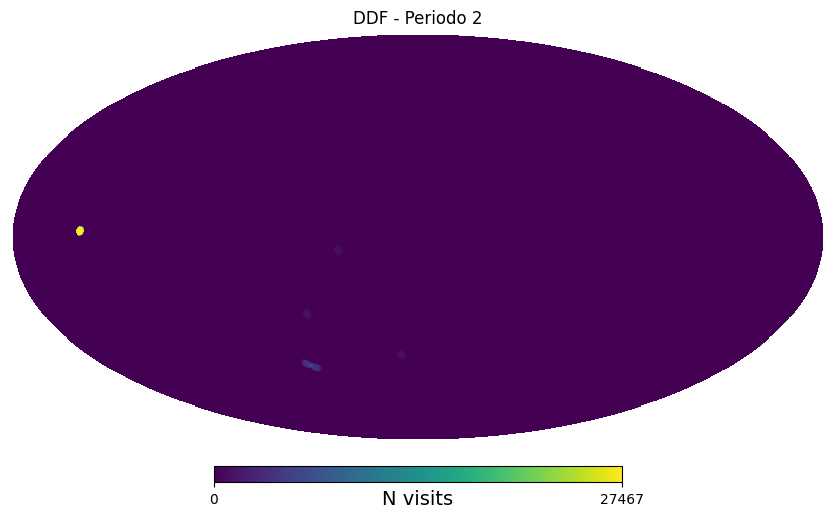

In [ ]:
# Period 2 for DDF: 545.5 days from the end of Period 1
year_index = 2
year_start_mjd = current_start_mjd_DDF
year_end_mjd = current_start_mjd_DDF + 545.5

print(f"\nSeleccionando DDF Periodo {year_index} (MJD {year_start_mjd:.2f} a {year_end_mjd:.2f})")

df_DDF_Period2 = df_DD[(df_DD['observationStartMJD'] >= year_start_mjd) &
                       (df_DD['observationStartMJD'] < year_end_mjd)].copy()

if not df_DDF_Period2.empty:
    DDF_tree_Period2 = BallTree(
        df_DDF_Period2[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    DDF_Period2_hp_rep = compute_hp_rep(df_DDF_Period2, DDF_tree_Period2, minVisits=1)
    plot_hp_rep(DDF_Period2_hp_rep, title=f'DDF - Periodo {year_index}')
    min_t_all = Time(min(df_DDF_Period2['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_DDF_Period2['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WDF Periodo {year_index}.")

# Update current_start_mjd_DDF for the next period
current_start_mjd_DDF = year_end_mjd


Seleccionando DDF Periodo 3 (MJD 61951.50 a 62497.00)
Finished compute healpy representation, total number of fields : 1708.
Observaciones 
 desde: (2028, 7, 5, 5, 54, 52.65588778) 
 hasta: (2029, 12, 26, 3, 26, 23.87725248)


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


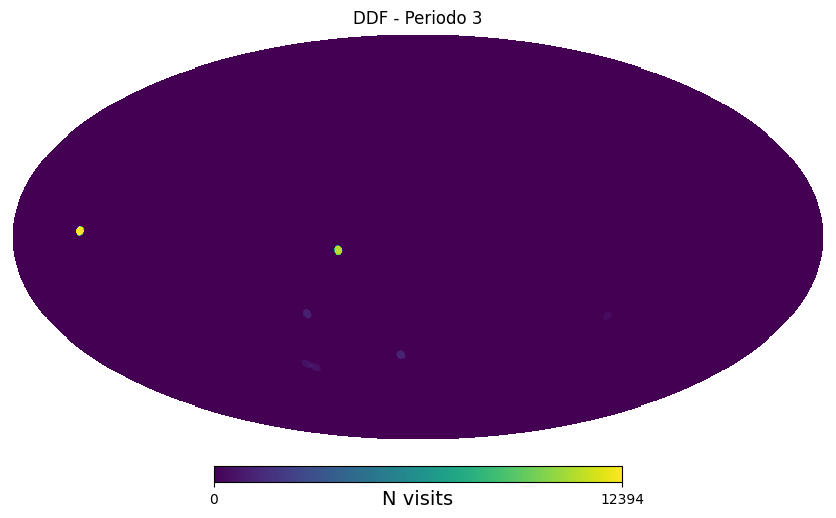

In [ ]:
# Period 3 for DDF: 545.5 days from the end of Period 2
year_index = 3
year_start_mjd = current_start_mjd_DDF
year_end_mjd = current_start_mjd_DDF + 545.5

print(f"\nSeleccionando DDF Periodo {year_index} (MJD {year_start_mjd:.2f} a {year_end_mjd:.2f})")

df_DDF_Period3 = df_DD[(df_DD['observationStartMJD'] >= year_start_mjd) &
                       (df_DD['observationStartMJD'] < year_end_mjd)].copy()

if not df_DDF_Period3.empty:
    DDF_tree_Period3 = BallTree(
        df_DDF_Period3[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    DDF_Period3_hp_rep = compute_hp_rep(df_DDF_Period3, DDF_tree_Period3, minVisits=1)
    plot_hp_rep(DDF_Period3_hp_rep, title=f'DDF - Periodo {year_index}')
    min_t_all = Time(min(df_DDF_Period3['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_DDF_Period3['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WDF Periodo {year_index}.")

# Update current_start_mjd_DDF for the next period
current_start_mjd_DDF = year_end_mjd


Seleccionando DDF Periodo 4 (MJD 62497.00 a 63042.50)
Finished compute healpy representation, total number of fields : 1714.
Observaciones 
 desde: (2029, 12, 27, 1, 27, 23.40088398) 
 hasta: (2031, 6, 25, 6, 18, 15.84296287)


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


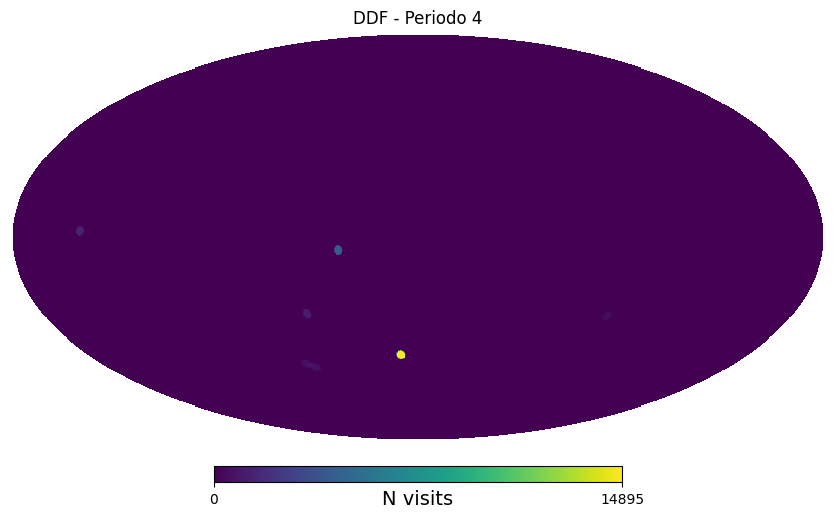

In [ ]:
# Period 4 for DDF: 545.5 days from the end of Period 3
year_index = 4
year_start_mjd = current_start_mjd_DDF
year_end_mjd = current_start_mjd_DDF + 545.5

print(f"\nSeleccionando DDF Periodo {year_index} (MJD {year_start_mjd:.2f} a {year_end_mjd:.2f})")

df_DDF_Period4 = df_DD[(df_DD['observationStartMJD'] >= year_start_mjd) &
                       (df_DD['observationStartMJD'] < year_end_mjd)].copy()

if not df_DDF_Period4.empty:
    DDF_tree_Period4 = BallTree(
        df_DDF_Period4[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    DDF_Period4_hp_rep = compute_hp_rep(df_DDF_Period4, DDF_tree_Period4, minVisits=1)
    plot_hp_rep(DDF_Period4_hp_rep, title=f'DDF - Periodo {year_index}')
    min_t_all = Time(min(df_DDF_Period4['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_DDF_Period4['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WDF Periodo {year_index}.")

# Update current_start_mjd_DDF for the next period
current_start_mjd_DDF = year_end_mjd


Seleccionando DDF Periodo 5 (MJD 63042.50 a 63588.00)
Finished compute healpy representation, total number of fields : 1712.


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Observaciones 
 desde: (2031, 6, 26, 0, 36, 36.9680995) 
 hasta: (2032, 12, 21, 2, 34, 30.47504776)


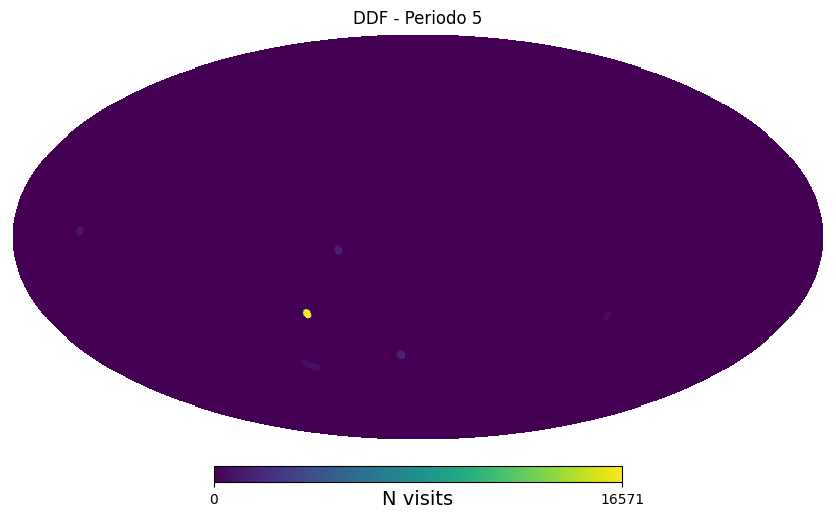

In [ ]:
# Period 5 for DDF: 545.5 days from the end of Period 4
year_index = 5
year_start_mjd = current_start_mjd_DDF
year_end_mjd = current_start_mjd_DDF + 545.5

print(f"\nSeleccionando DDF Periodo {year_index} (MJD {year_start_mjd:.2f} a {year_end_mjd:.2f})")

df_DDF_Period5 = df_DD[(df_DD['observationStartMJD'] >= year_start_mjd) &
                       (df_DD['observationStartMJD'] < year_end_mjd)].copy()

if not df_DDF_Period5.empty:
    DDF_tree_Period5 = BallTree(
        df_DDF_Period5[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    DDF_Period5_hp_rep = compute_hp_rep(df_DDF_Period5, DDF_tree_Period5, minVisits=1)
    plot_hp_rep(DDF_Period5_hp_rep, title=f'DDF - Periodo {year_index}')
    min_t_all = Time(min(df_DDF_Period5['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_DDF_Period5['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WDF Periodo {year_index}.")

# Update current_start_mjd_DDF for the next period
current_start_mjd_DDF = year_end_mjd


Seleccionando DDF Periodo 6 (MJD 63588.00 a 64133.50)
Finished compute healpy representation, total number of fields : 1708.
Observaciones 
 desde: (2032, 12, 22, 1, 24, 16.49552329) 
 hasta: (2034, 6, 18, 23, 19, 41.49194405)


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


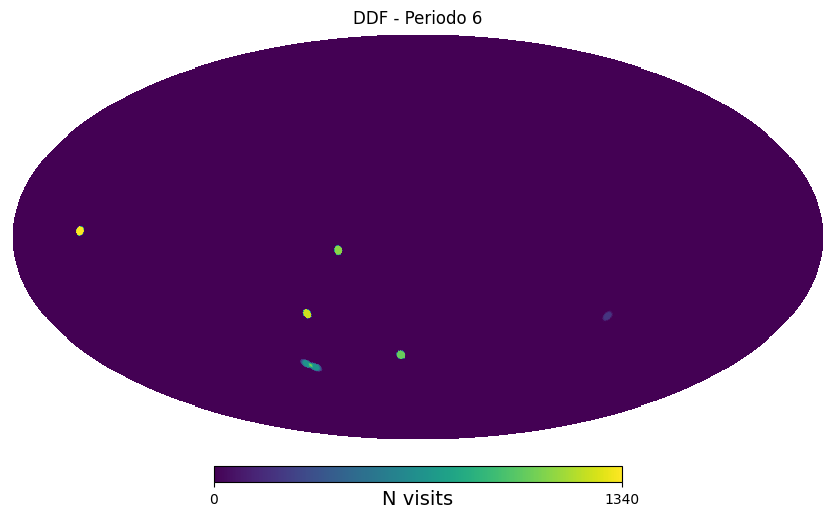

In [ ]:
# Period 6 for DDF: 545.5 days from the end of Period 4
year_index = 6
year_start_mjd = current_start_mjd_DDF
year_end_mjd = current_start_mjd_DDF + 545.5

print(f"\nSeleccionando DDF Periodo {year_index} (MJD {year_start_mjd:.2f} a {year_end_mjd:.2f})")

df_DDF_Period6 = df_DD[(df_DD['observationStartMJD'] >= year_start_mjd) &
                       (df_DD['observationStartMJD'] < year_end_mjd)].copy()

if not df_DDF_Period6.empty:
    DDF_tree_Period6 = BallTree(
        df_DDF_Period6[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    DDF_Period6_hp_rep = compute_hp_rep(df_DDF_Period6, DDF_tree_Period6, minVisits=1)
    plot_hp_rep(DDF_Period6_hp_rep, title=f'DDF - Periodo {year_index}')
    min_t_all = Time(min(df_DDF_Period6['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_DDF_Period6['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WDF Periodo {year_index}.")

# Update current_start_mjd_DDF for the next period
current_start_mjd_DDF = year_end_mjd


Seleccionando DDF Periodo 7 (MJD 64133.50 a 64679.00)
Finished compute healpy representation, total number of fields : 1415.
Observaciones 
 desde: (2034, 6, 23, 5, 44, 53.44370971) 
 hasta: (2035, 11, 1, 6, 4, 46.32362487)


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


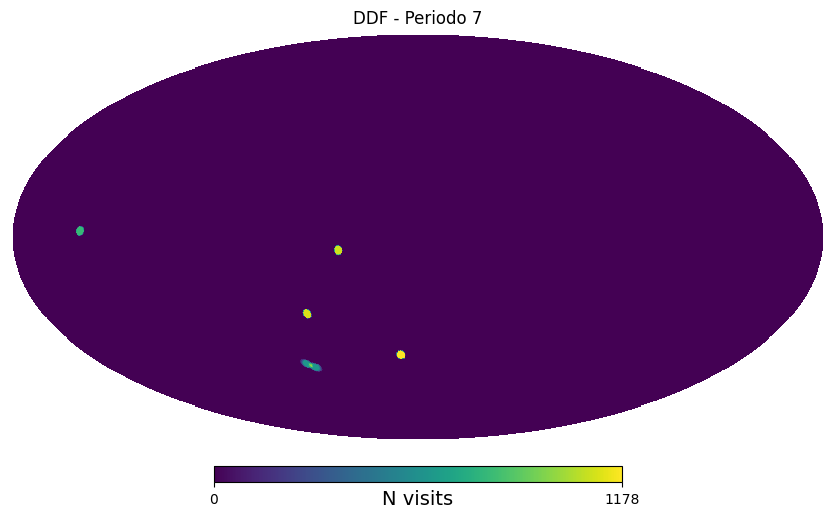

In [ ]:
# Period 7 for DDF: 545.5 days from the end of Period 4
year_index = 7
year_start_mjd = current_start_mjd_DDF
year_end_mjd = current_start_mjd_DDF + 545.5

print(f"\nSeleccionando DDF Periodo {year_index} (MJD {year_start_mjd:.2f} a {year_end_mjd:.2f})")

df_DDF_Period7 = df_DD[(df_DD['observationStartMJD'] >= year_start_mjd) &
                       (df_DD['observationStartMJD'] < year_end_mjd)].copy()

if not df_DDF_Period7.empty:
    DDF_tree_Period7 = BallTree(
        df_DDF_Period7[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    DDF_Period7_hp_rep = compute_hp_rep(df_DDF_Period7, DDF_tree_Period7, minVisits=1)
    plot_hp_rep(DDF_Period7_hp_rep, title=f'DDF - Periodo {year_index}')
    min_t_all = Time(min(df_DDF_Period7['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_all = Time(max(df_DDF_Period7['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones \n desde: {} \n hasta: {}'.format(min_t_all, max_t_all))
else:
    print(f"No se encontraron datos para el WDF Periodo {year_index}.")

# Update current_start_mjd_DDF for the next period
current_start_mjd_DDF = year_end_mjd

### Visualizacion de temporadas segun plan de observacion


/tmp/ipython-input-197915394.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


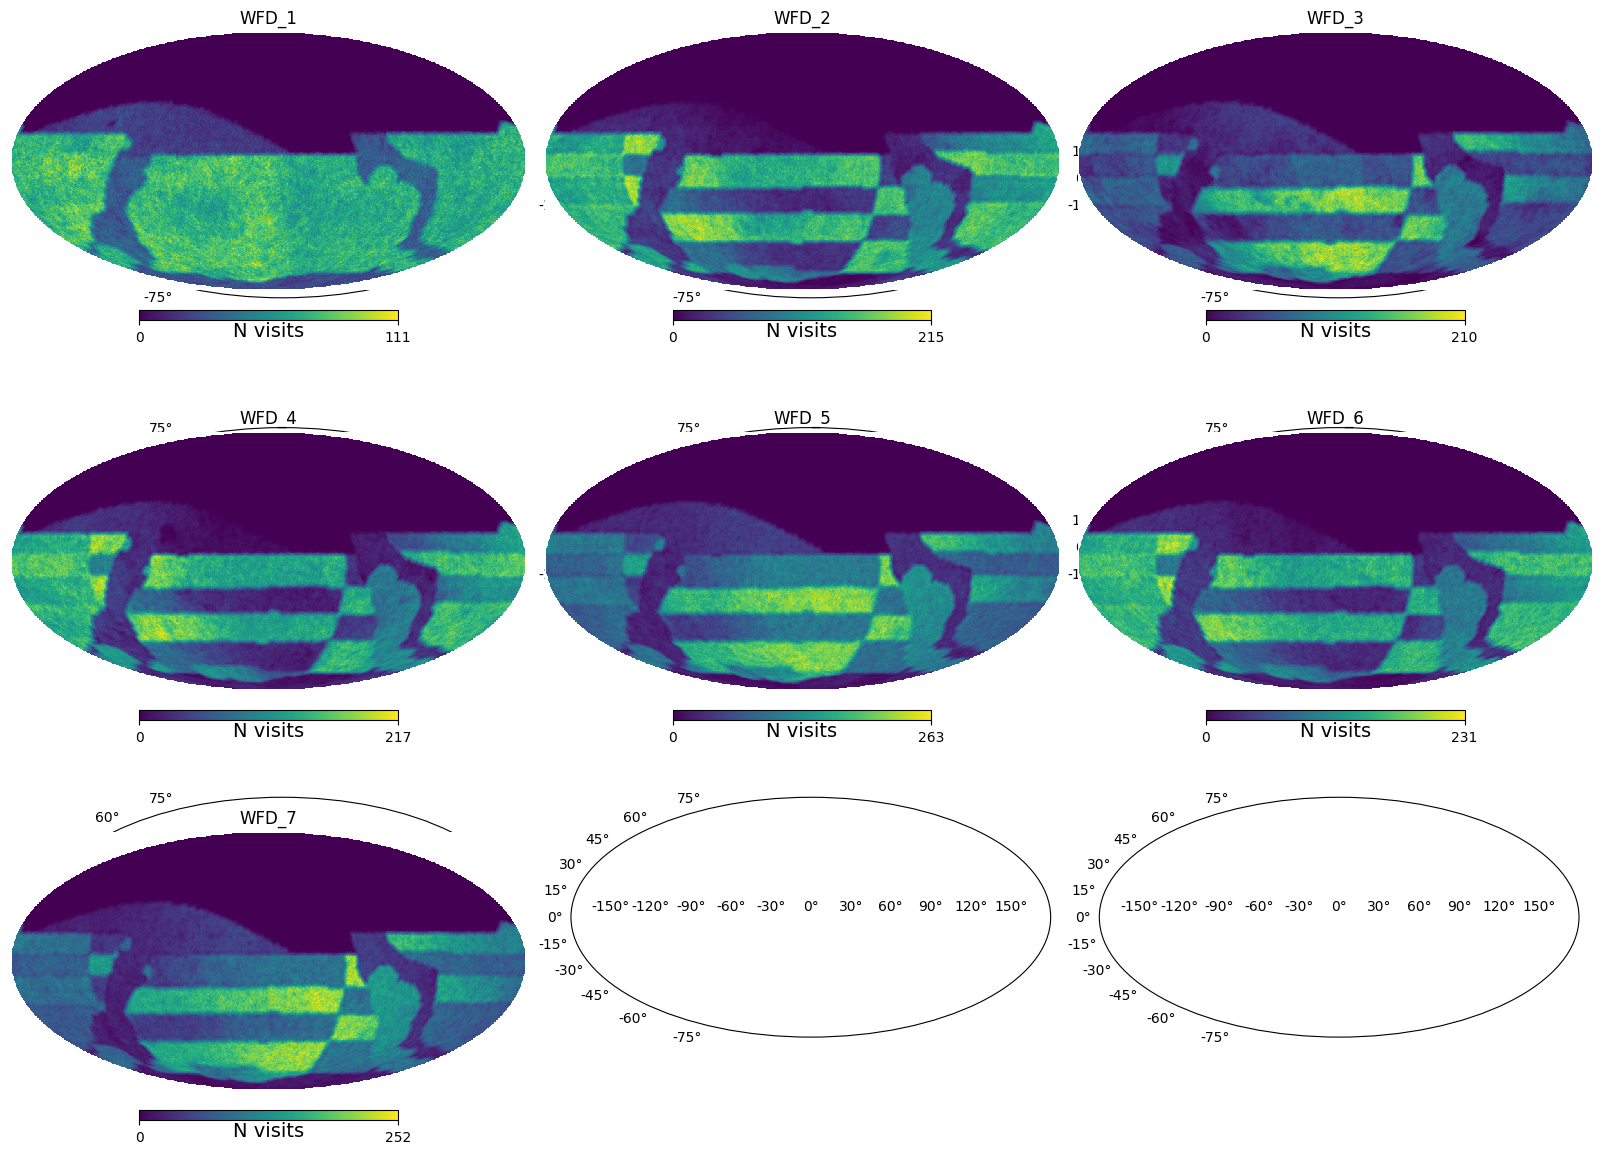

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12), subplot_kw=dict(projection='mollweide'))
axes = axes.flatten()

seasons = range(1,8)
hp_reps = [WFD_Period1_hp_rep, WFD_Period2_hp_rep, WFD_Period3_hp_rep, WFD_Period4_hp_rep, WFD_Period5_hp_rep, WFD_Period6_hp_rep, WFD_Period7_hp_rep]

for i, season in enumerate(seasons):
    if i < len(hp_reps):
        hp_rep = hp_reps[i]
        # Reset the index to access the ipix column
        hp_rep_reset = hp_rep.reset_index()

        ipix_map = np.zeros(hp.nside2npix(hp_rep_reset.attrs["nside"]))
        ipix_map[hp_rep_reset.ipix.values] = hp_rep_reset.n_visits.values

        hp.mollview(map=ipix_map, unit="N visits", fig=fig, sub=(3, 3, i + 1), title=f'WFD_{season}')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3681312363.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


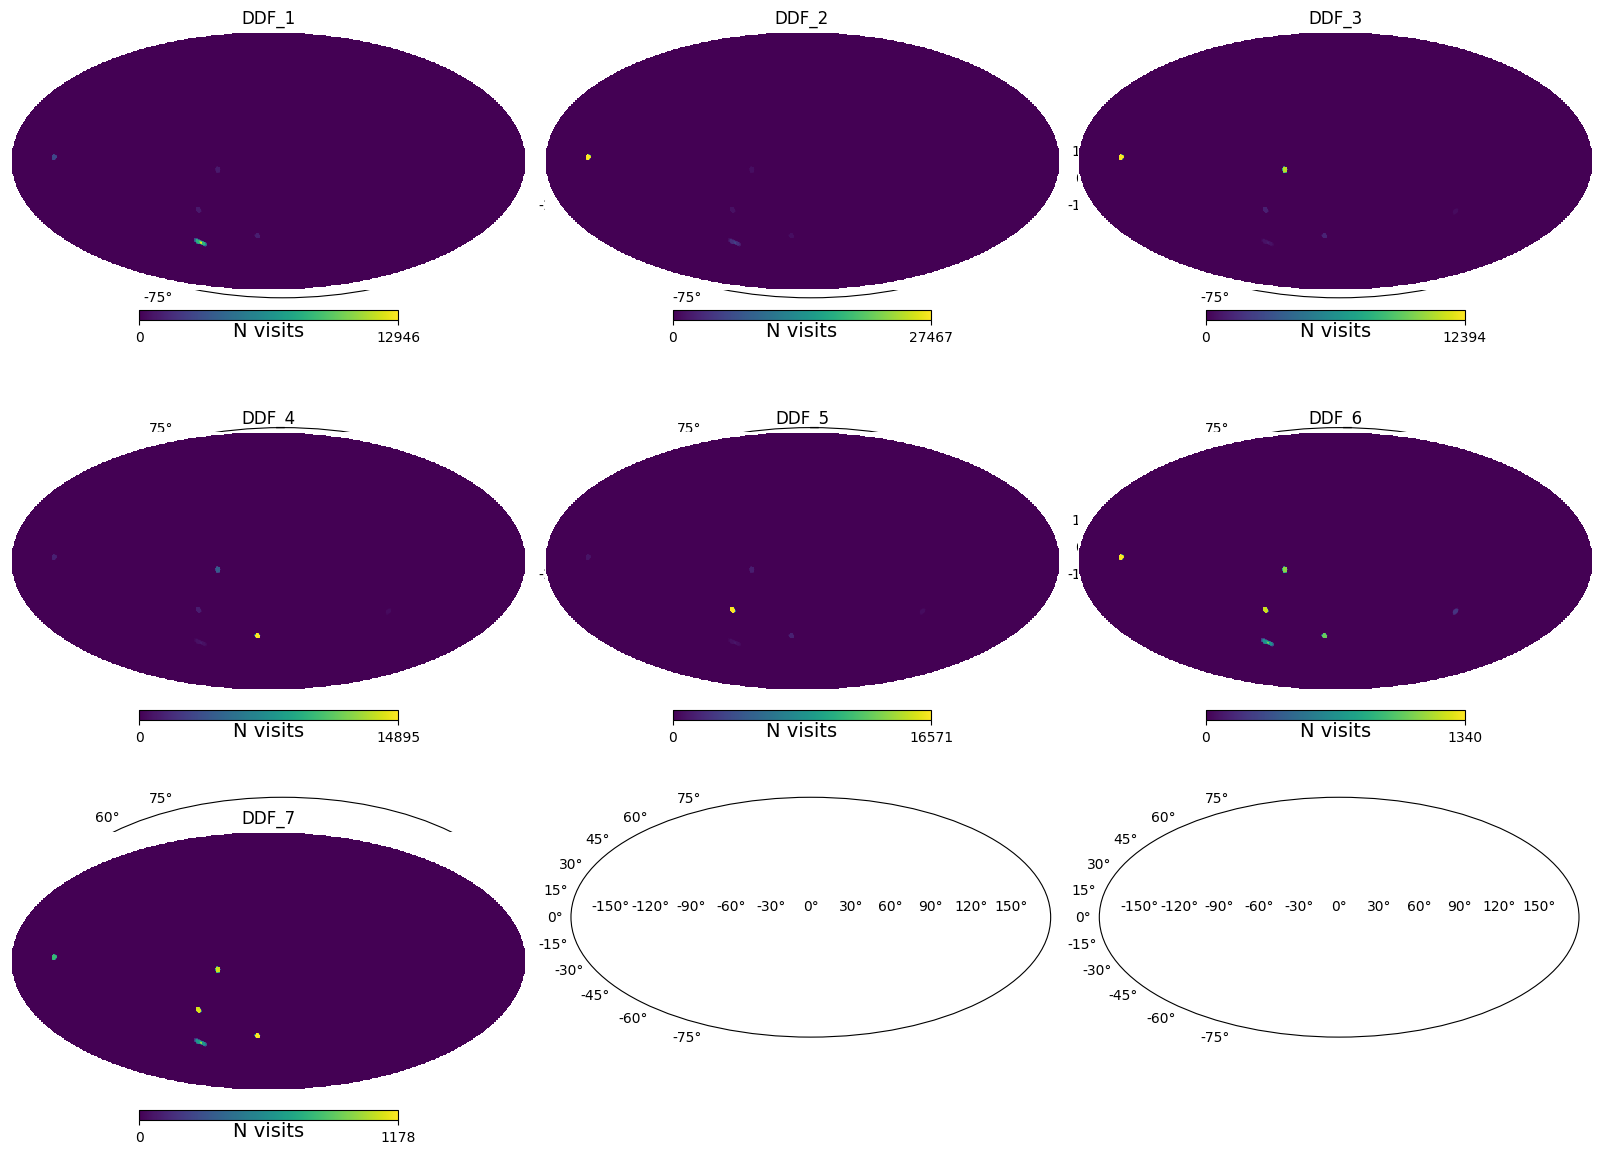

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12), subplot_kw=dict(projection='mollweide'))
axes = axes.flatten()

seasons = range(1,8)
hp_reps = [DDF_Period1_hp_rep, DDF_Period2_hp_rep, DDF_Period3_hp_rep, DDF_Period4_hp_rep, DDF_Period5_hp_rep, DDF_Period6_hp_rep, DDF_Period7_hp_rep]

for i, season in enumerate(seasons):
    if i < len(hp_reps):
        hp_rep = hp_reps[i]
        # Reset the index to access the ipix column
        hp_rep_reset = hp_rep.reset_index()

        ipix_map = np.zeros(hp.nside2npix(hp_rep_reset.attrs["nside"]))
        ipix_map[hp_rep_reset.ipix.values] = hp_rep_reset.n_visits.values

        hp.mollview(map=ipix_map, unit="N visits", fig=fig, sub=(3, 3, i + 1), title=f'DDF_{season}')

plt.tight_layout()
plt.show()

## Recorte temporal

Realizaremos un recorte temporal para poder tener dos temporadas completas de WFD en el archivo SIMLIB, se usara el mismo periodo temporal para el campo DDF, correspondiente a las fechas desde el 1 de noviembre de 2025 hasta el 31 de diciembre de 2029

/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


MJD de inicio de TODO el survey: 60980.00162606769
MJD de fin del periodo (31 de Diciembre de 2029): 62501.00

--- Procesando WFD hasta 31 de Diciembre de 2029 ---
Finished compute healpy representation, total number of fields : 534908.


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Observaciones WFD 
 desde: (2025, 11, 1, 0, 32, 23.17414379) 
 hasta: (2029, 12, 30, 7, 26, 33.31435219)

--- Procesando DDF hasta 31 de Diciembre de 2029 ---
Finished compute healpy representation, total number of fields : 1712.


/usr/local/lib/python3.12/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Observaciones DDF 
 desde: (2025, 11, 2, 7, 42, 27.53178321) 
 hasta: (2029, 12, 30, 7, 43, 57.8156465)


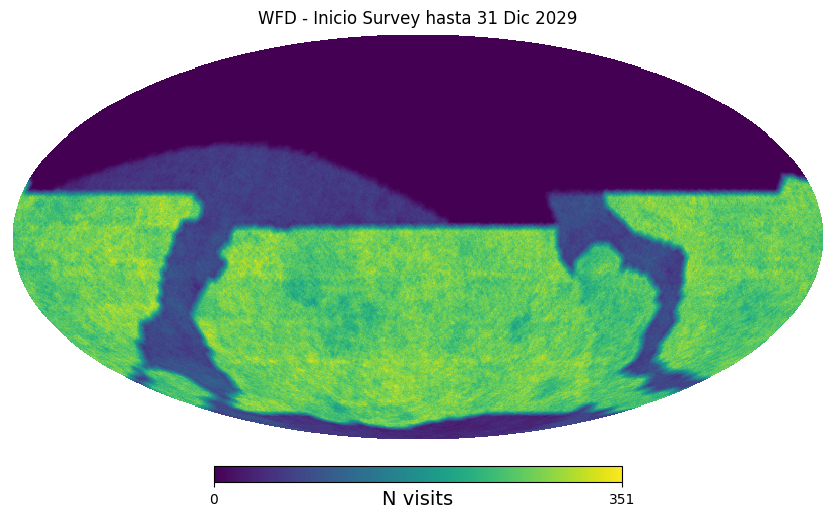

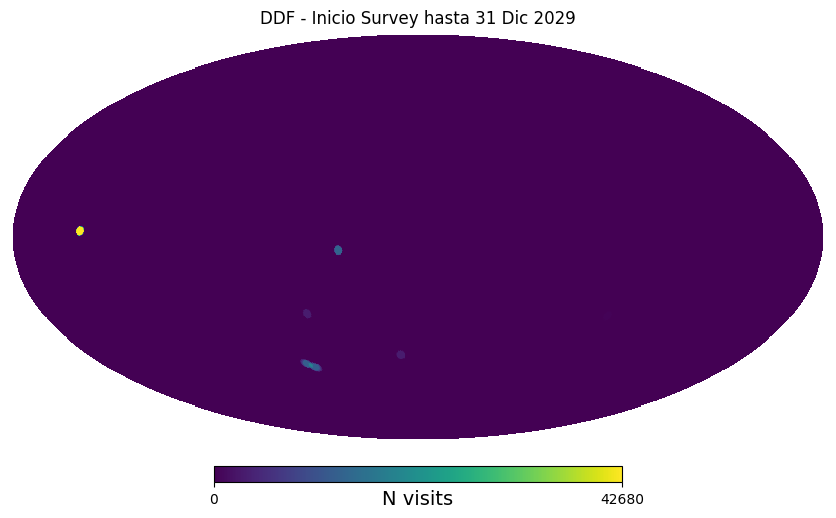

In [ ]:
# Calculate MJD for December 31st, 2029
end_date_2029 = Time('2029-12-31', format='iso', scale='utc')
mjd_2029_dec31 = end_date_2029.mjd

# Get the start MJD of the entire survey
MJD_inicio_total = df['observationStartMJD'].min()
print(f"MJD de inicio de TODO el survey: {MJD_inicio_total}")
print(f"MJD de fin del periodo (31 de Diciembre de 2029): {mjd_2029_dec31:.2f}")

# Filter WFD data for the period
print("\n--- Procesando WFD hasta 31 de Diciembre de 2029 ---")
df_WFD_until_2029 = df_WFD[(df_WFD['observationStartMJD'] >= MJD_inicio_total) &
                          (df_WFD['observationStartMJD'] <= mjd_2029_dec31)].copy()

if not df_WFD_until_2029.empty:
    # Create BallTree for WFD data
    WFD_tree_until_2029 = BallTree(
        df_WFD_until_2029[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    # Compute hp_rep for WFD data (minVisits=1 to show all fields with at least one visit)
    WFD_until_2029_hp_rep = compute_hp_rep(df_WFD_until_2029, WFD_tree_until_2029, minVisits=1)

    # Plot healpix representation for WFD
    plot_hp_rep(WFD_until_2029_hp_rep, title='WFD - Inicio Survey hasta 31 Dic 2029')

    # Print time range for WFD
    min_t_WFD = Time(min(df_WFD_until_2029['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_WFD = Time(max(df_WFD_until_2029['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones WFD \n desde: {} \n hasta: {}'.format(min_t_WFD, max_t_WFD))
else:
    print("No se encontraron datos WFD para este periodo.")

# Filter DDF data for the period
print("\n--- Procesando DDF hasta 31 de Diciembre de 2029 ---")
df_DDF_until_2029 = df_DD[(df_DD['observationStartMJD'] >= MJD_inicio_total) &
                         (df_DD['observationStartMJD'] <= mjd_2029_dec31)].copy()

if not df_DDF_until_2029.empty:
    # Create BallTree for DDF data
    DDF_tree_until_2029 = BallTree(
        df_DDF_until_2029[["_dec", "_ra"]].values, leaf_size=50, metric="haversine"
    )
    # Compute hp_rep for DDF data (minVisits=1 to show all fields with at least one visit)
    DDF_until_2029_hp_rep = compute_hp_rep(df_DDF_until_2029, DDF_tree_until_2029, minVisits=1)

    # Plot healpix representation for DDF
    plot_hp_rep(DDF_until_2029_hp_rep, title='DDF - Inicio Survey hasta 31 Dic 2029')

    # Print time range for DDF
    min_t_DDF = Time(min(df_DDF_until_2029['observationStartMJD']), format='mjd').to_value('ymdhms')
    max_t_DDF = Time(max(df_DDF_until_2029['observationStartMJD']), format='mjd').to_value('ymdhms')
    print('Observaciones DDF \n desde: {} \n hasta: {}'.format(min_t_DDF, max_t_DDF))
else:
    print("No se encontraron datos DDF para este periodo.")

In [ ]:
print(min(df_WFD_until_2029['observationStartMJD']), max(df_WFD_until_2029['observationStartMJD']))

60980.02249044148 62500.310107805


In [ ]:
print(min(df_DDF_until_2029['observationStartMJD']), max(df_DDF_until_2029['observationStartMJD']))

60981.32115198823 62500.32219694035


Estas fechas se ajustan a cada uno de los archivos .input de todas las clases, se deben incluir con los valores de la fecha juliana modificada (MJD)


##Generación de Archivos SIMLIB
Este es el paso final donde los datos procesados se escriben en el formato de texto plano que SNANA requiere.



###Definición de Funciones SIMLIB

Se definen varias funciones auxiliares (como get_SIMLIB_doc, get_SIMLIB_header, LIBheader, LIBdata, LIBfooter) que estructuran el texto de salida. Estas funciones generan los encabezados de documentación, los encabezados de librería (LIBID) y el formato de las líneas de observación individuales.

In [ ]:
def get_SIMLIB_doc(hp_rep,df,author_name,survey_hosts=None):
    """Give the DOCUMENTATION string for SIMLIB.

    Returns
    -------
    str
        DOCUMENTATION string
    """
    minMJD = df["observationStartMJD"].min()
    maxMJD = df["observationStartMJD"].max()
    date = datetime.datetime.now()
    OpSimFile = df.attrs["OpSimFile"]
    doc = "DOCUMENTATION:\n"
    doc += f"    PURPOSE: simulate LSST based on mock opsim version {OpSimFile}\n"
    doc += "    INTENT:   Nominal\n"
    doc += "    USAGE_KEY: SIMLIB_FILE\n"
    doc += "    USAGE_CODE: snlc_sim.exe\n"
    doc += "    VALIDATION_SCIENCE: \n"
    doc += "    NOTES: \n"
    doc += "        PARAMS MINMJD: {:.4f}\n".format(minMJD)
    doc += "        PARAMS MAXMJD: {:.4f}\n".format(maxMJD)
    doc += "        PARAMS TOTAL_AREA: {:.3f}\n".format(
        hp_rep.attrs["survey_area_deg"]
    )
    doc += "        PARAMS SOLID_ANGLE: {:.3f}\n".format(
        hp_rep.attrs["survey_area_rad"]
    )
    if survey_hosts is not None:
        doc += "        ASSOCIATED HOSTLIB: {}\n".format(
            out_path.with_suffix(".HOSTLIB").absolute()
        )
    doc += "    VERSIONS:\n"
    doc += f'    - DATE : {date.strftime(format="%Y-%m")}\n'
    doc += f"    AUTHORS : {author_name}, OpSimSummaryV2 version {opsim.__version__}\n"
    doc += "DOCUMENTATION_END:\n"
    return doc

In [ ]:
def get_SIMLIB_header(hp_rep, saturation_flag=1024, comments="\n"):
    """Give the SIMLIB header string.

    Parameters
    ----------
    saturation_flag : int, optional
        The flag corresponding to saturated obs, by default 1024
    comments : str, optional
        Comments to add to the header, by default '\\n'

    Returns
    -------
    str
        The SIMLIB header string.
    """
    try:
        user = os.getlogin()
    except:
        user = "NONE"
    try:
        host = os.getenv("HOSTNAME")
    except:
        host = "NONE"
    # comment: I would like to generalize ugrizY to a sort but am not sure
    # of the logic for other filter names. so ducking for now
    header = "\n\n\n"
    header += "SURVEY: LSST   FILTERS: ugrizY  TELESCOPE: LSST\n"
    header += "USER: {0:}     HOST: {1}\n".format(user, host)
    header += f"NLIBID: {len(hp_rep)}\n"
    header += "NPE_PIXEL_SATURATE:   100000\n"
    header += f"PHOTFLAG_SATURATE:    {saturation_flag}\n"
    header += comments + "\n"
    header += "BEGIN LIBGEN\n"
    return header

###Formateo

Escribe el LIBheader (metadatos del campo: ID, RA, Dec, MWEBV).



In [ ]:
def LIBheader(LIBID, ra, dec,df, mwebv=0.0, groupID=None):
    """Give the string of the header of a LIB entry.

    Parameters
    ----------
    LIBID : int
        The LIBID of the entry.
    ra : float
        RA [deg] coordinate of the entry
    dec : float
        Dec [deg] coordinate of the entry
    opsimdf : pandas.DataFrame
        LIB entry observations
    mwebv: float, optional
        MWEBV of the entry, default = 0.0
    groupID : int, optional
        GROUPID of the entry used to match with HOSTLIB hosts.

    Returns
    -------
    str
        The LIB entry header string.
    """
    nobs = len(df)
    # String formatting
    s = "# --------------------------------------------" + "\n"
    s += "LIBID: {0:10d}".format(LIBID) + "\n"
    tmp = "RA: {0:+10.6f} DEC: {1:+10.6f}   NOBS: {2:10d} MWEBV: {3:5.2f}"
    tmp += " PIXSIZE: {4:5.3f}"
    s += (
        tmp.format(ra, dec, nobs, mwebv, 0.2) + "\n"
    )
    if groupID is not None:
        s += f"HOSTLIB_GROUPID: {groupID}" + "\n"
    s += "#                           CCD  CCD         PSF1 PSF2 PSF2/1" + "\n"
    s += (
        "#     MJD      ID*NEXPOSE  FLT GAIN NOISE SKYSIG (pixels)  RATIO  ZPTAVG ZPTERR  MAG"
        + "\n"
    )
    return s

In [ ]:
ZPTNoise=0.005
CCDgain=1.0
CCDnoise=0.25
def init_dataline():
    f = lambda expMJD, ObsID, BAND, SKYSIG, PSF, ZPT: ut.dataline(
        expMJD,
        ObsID,
        BAND,
        CCDgain,
        CCDnoise,
        SKYSIG,
        PSF,
        ZPT,
        ZPTNoise,
    )

    return np.vectorize(f)

dataline = init_dataline()

Escribe las líneas LIBdata (una por cada visita) con la información crucial: MJD, Banda (Filtro), SKYSIG (brillo del cielo), PSF (seeing), y ZPT (punto cero).

In [ ]:
def LIBdata(opsimdf):
    """Give the string of a LIB entry.

    Parameters
    ----------
    opsimdf : pandas.DataFrame
        LIB entry observations

    Returns
    -------
    str
        The str of the LIB entry.
    """
    opsimdf["BAND"] = opsimdf["BAND"].map(lambda x: x.upper() if x == "y" else x)
    lib = "\n".join(
        dataline(
            opsimdf["expMJD"].values,
            opsimdf["ObsID"].values,
            opsimdf["BAND"].values,
            opsimdf["SKYSIG"].values,
            opsimdf["PSF"].values,
            opsimdf["ZPT"].values,
        )
    )
    return lib + "\n"

Escribe el LIBfooter para cerrar la entrada del campo.

In [ ]:
def LIBfooter(LIBID):
    """Give the string of a LIB entry footer.

    Parameters
    ----------
    LIBID : int
        The LIBID of the entry

    Returns
    -------
    str
        The string of a LIB entry footer
    """
    footer = "END_LIBID: {0:10d}".format(LIBID)
    footer += "\n"
    return footer


In [ ]:
def get_SIMLIB_footer(hp_rep):
    """Give SIMLIB footer."""
    s = "END_OF_SIMLIB:    {0:10d} ENTRIES".format(
        len(hp_rep) # Corrected to use the length of hp_rep
    )
    return s

In [ ]:
def write_SIMLIB(tree, hp_rep,df,out_path,author_name,survey_hosts=None, write_batch_size=10, buffer_size=8192):
    """write the SIMLIB (and the HOSTLIB) file(s).

    Parameters
    ----------
    write_batch_size : int
        Number of LIBID to write at the same time
    buffer_size : int
        buffering option for open() function
    """
    tstart = time.time()
    print(f"Writing SIMLIB in {out_path}")

    with open(out_path, "w", buffering=buffer_size) as simlib_file:
        simlib_file.write(get_SIMLIB_doc(hp_rep,df,author_name))
        simlib_file.write(get_SIMLIB_header(hp_rep))

        bcount = 0
        simlibstr = ""
        for (i, field), obs in zip(
            hp_rep.iterrows(), get_survey_obs(tree, df, hp_rep)
        ):
            LIBID = i
            RA = np.degrees(field.hp_ra)
            DEC = np.degrees(field.hp_dec)
            if survey_hosts is not None:
                groupID = LIBID
            else:
                groupID = None

            simlibstr += LIBheader(LIBID, RA, DEC, obs, groupID=groupID)
            simlibstr += LIBdata(obs)
            simlibstr += LIBfooter(LIBID)

            if not bcount % write_batch_size:
                simlib_file.write(simlibstr)
                simlibstr = ""

            bcount += 1

        simlib_file.write(simlibstr)
        simlib_file.write(get_SIMLIB_footer(hp_rep))

    print(f"SIMLIB wrote in {time.time() - tstart:.2f} sec.\n")


###Escritura de SIMLIB

In [ ]:
os.getcwd()+'/DD_SIMLIB.SIMLIB'

'/content/DD_SIMLIB.SIMLIB'

In [ ]:
out_path_DD = os.getcwd()+'/DD_SIMLIB.SIMLIB'
out_path_WFD = os.getcwd()+'/WFD_SIMLIB.SIMLIB'

In [ ]:
write_SIMLIB(DD_tree,sample_DD,df_DD, out_path=out_path_DD, author_name='Mauricio Valenzuela C')

Writing SIMLIB in /content/DD_SIMLIB.SIMLIB
SIMLIB wrote in 132.03 sec.



In [ ]:
write_SIMLIB(WFD_tree,sample_WFD,df_WFD, out_path=out_path_WFD, author_name='Mauricio Valenzuela C')

Writing SIMLIB in /content/WFD_SIMLIB.SIMLIB
SIMLIB wrote in 233.30 sec.

